In [1]:
%load_ext autoreload
%autoreload 2

In [25]:
import os
import time
import shutil
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.cuda.comm
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
from models.ST_Former import GenerateModel
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy as np
import datetime
from dataloader.dataset_NIA import train_data_loader, test_data_loader
import wandb

from runner_helper import *

class Pseudoarg():
    def __init__(self):
        self.workers = 2
        self.epochs = 300
        self.start_epoch = 0
        self.batch_size = 16
        self.lr = 0.001
        self.momentum = 0.9
        self.weight_decay = 1e-4
        self.print_freq = 10
        self.resume = "nia/checkpoint/[03-12]-[22:20]-set0-model_best.pth"
        self.data_set = 0
        
args = Pseudoarg()

In [3]:
model = GenerateModel()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = torch.nn.DataParallel(model).cuda()

In [26]:
use_cuda = torch.cuda.is_available()
if use_cuda:
    print('__CUDNN VERSION:', torch.backends.cudnn.version())
    print('__Number CUDA Devices:', torch.cuda.device_count())
    print('__CUDA Device Name:',torch.cuda.get_device_name(0))
    print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)
else:
    print("Can't use CUDA")
    print('__CUDNN VERSION:', torch.backends.cudnn.version())
    print('__Number CUDA Devices:', torch.cuda.device_count())
    print('__CUDA Device Name:',torch.cuda.get_device_name(0))
    print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)

__CUDNN VERSION: 8500
__Number CUDA Devices: 1
__CUDA Device Name: NVIDIA GeForce RTX 4090
__CUDA Device Total Memory [GB]: 25.393692672


In [27]:
now = datetime.datetime.now()
time_str = now.strftime("[%m-%d]-[%H:%M]-")
project_path = './nia/'
log_txt_path = project_path + 'log/' + time_str + 'set' + str(args.data_set) + '-log.txt'
log_curve_path = project_path + 'log/' + time_str + 'set' + str(args.data_set) + '-log.png'
checkpoint_path = project_path + 'checkpoint/' + time_str + 'set' + str(args.data_set) + '-model.pth'
best_checkpoint_path = project_path + 'checkpoint/' + time_str + 'set' + str(args.data_set) + '-model_best.pth'


In [33]:
#def main():
best_acc = 0
recorder = RecorderMeter(args.epochs)
print('Training time: ' + now.strftime("%m-%d %H:%M"))
print('Training set: set ' + str(args.data_set))
os.makedirs("./Former-DFER/data/log",exist_ok = True)
with open(log_txt_path, 'a') as f:
    f.write('The training set: set ' + str(args.data_set) + '\n')

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
# create model and load pre_trained parameters

# define loss function (criterion) and optimizer
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), args.lr, 
                             # momentum=args.momentum, 
                             weight_decay=args.weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)


Training time: 03-13 01:07
Training set: set 0
Using cuda device


In [34]:
if args.resume:
    if os.path.isfile(args.resume):
        print("=> loading checkpoint '{}'".format(args.resume))
        checkpoint = torch.load(args.resume)
        args.start_epoch = checkpoint['epoch']
        best_acc = checkpoint['best_acc']
        recorder = checkpoint['recorder']
        best_acc = best_acc.cuda()
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        print("=> loaded checkpoint '{}' (epoch {})".format(args.resume, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(args.resume))
cudnn.benchmark = True

=> loading checkpoint 'nia/checkpoint/[03-12]-[22:20]-set0-model_best.pth'
=> loaded checkpoint 'nia/checkpoint/[03-12]-[22:20]-set0-model_best.pth' (epoch 81)


In [35]:
# Data loading code
train_data = train_data_loader(list_path=project_path + "validation.txt")
test_data = test_data_loader(list_path=project_path + "validation.txt")

train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=args.batch_size,
                                           shuffle=True,
                                           num_workers=args.workers,
                                           pin_memory=True,
                                           drop_last=True)
val_loader = torch.utils.data.DataLoader(test_data,
                                         batch_size=args.batch_size,
                                         shuffle=False,
                                         num_workers=args.workers,
                                         pin_memory=True)


log_txt_path = "./nia/train_run_log.txt"

video number:8641
video number:8641


In [36]:
len(train_data.video_list)

8641

In [39]:
start_time = datetime.datetime.now()
print('start :',start_time)

wandb.init(project='nia')
for epoch in range(args.start_epoch, args.epochs):
    inf = '********************' + str(epoch) + '********************'
    start_time = time.time()
    current_learning_rate = optimizer.state_dict()['param_groups'][0]['lr']

    with open(log_txt_path, 'a') as f:
        f.write(inf + '\n')
        f.write('Current learning rate: ' + str(current_learning_rate) + '\n')

    print(inf)
    print('Current learning rate: ', current_learning_rate)

    # train for one epoch
    train_acc, train_los = train(train_loader, model, criterion, optimizer, epoch, args)

    # evaluate on validation set
    val_acc, val_los = validate(val_loader, model, criterion, args)

    scheduler.step()

    # remember best acc and save checkpoint
    is_best = val_acc > best_acc
    best_acc = max(val_acc, best_acc)
    save_checkpoint({'epoch': epoch + 1,
                     'state_dict': model.state_dict(),
                     'best_acc': best_acc,
                     'optimizer': optimizer.state_dict(),
                     'recorder': recorder}, is_best)

    # print and save log
    epoch_time = time.time() - start_time
    recorder.update(epoch, train_los, train_acc, val_los, val_acc)
    recorder.plot_curve(log_curve_path)
    
    wandb.log({"Train_Loss" : train_los, "Accuracy": train_acc}, step = epoch)
    print('The best accuracy: {:.3f}'.format(best_acc.item()))
    print('An epoch time: {:.1f}s'.format(epoch_time))
    with open(log_txt_path, 'a') as f:
        f.write('The best accuracy: ' + str(best_acc.item()) + '\n')
        f.write('An epoch time: {:.1f}s' + str(epoch_time) + '\n')
    
end_time = datetime.datetime.now()
print('end :',end_time)

start : 2023-03-13 01:09:27.446682


********************81********************
Current learning rate:  1e-05
Epoch: [81][  0/540]	Loss 0.9511 (0.9511)	Accuracy 43.750 (43.750)
Epoch: [81][ 10/540]	Loss 0.9439 (1.0053)	Accuracy 62.500 (47.159)
Epoch: [81][ 20/540]	Loss 0.8482 (1.0410)	Accuracy 62.500 (47.024)
Epoch: [81][ 30/540]	Loss 0.8827 (1.0291)	Accuracy 62.500 (47.984)
Epoch: [81][ 40/540]	Loss 1.1463 (1.0440)	Accuracy 37.500 (47.256)
Epoch: [81][ 50/540]	Loss 1.0767 (1.0477)	Accuracy 43.750 (48.039)
Epoch: [81][ 60/540]	Loss 0.9668 (1.0564)	Accuracy 50.000 (48.053)
Epoch: [81][ 70/540]	Loss 1.1135 (1.0454)	Accuracy 43.750 (49.384)
Epoch: [81][ 80/540]	Loss 0.8200 (1.0396)	Accuracy 56.250 (50.000)
Epoch: [81][ 90/540]	Loss 1.0863 (1.0430)	Accuracy 50.000 (49.931)
Epoch: [81][100/540]	Loss 0.8829 (1.0461)	Accuracy 62.500 (50.000)
Epoch: [81][110/540]	Loss 1.1623 (1.0543)	Accuracy 37.500 (49.718)
Epoch: [81][120/540]	Loss 1.0069 (1.0473)	Accuracy 50.000 (49.845)
Epoch: [81][130/540]	Loss 1.2298 (1.0486)	Accuracy 31.25

Epoch: [82][150/540]	Loss 1.1902 (1.0690)	Accuracy 37.500 (49.503)
Epoch: [82][160/540]	Loss 1.1470 (1.0687)	Accuracy 37.500 (49.767)
Epoch: [82][170/540]	Loss 1.0391 (1.0682)	Accuracy 37.500 (49.525)
Epoch: [82][180/540]	Loss 1.1523 (1.0634)	Accuracy 50.000 (49.931)
Epoch: [82][190/540]	Loss 1.1907 (1.0642)	Accuracy 18.750 (49.771)
Epoch: [82][200/540]	Loss 1.3232 (1.0701)	Accuracy 25.000 (49.378)
Epoch: [82][210/540]	Loss 0.9223 (1.0723)	Accuracy 56.250 (48.874)
Epoch: [82][220/540]	Loss 1.0901 (1.0721)	Accuracy 50.000 (48.840)
Epoch: [82][230/540]	Loss 0.7621 (1.0757)	Accuracy 81.250 (48.837)
Epoch: [82][240/540]	Loss 0.8296 (1.0731)	Accuracy 56.250 (49.015)
Epoch: [82][250/540]	Loss 0.9971 (1.0700)	Accuracy 50.000 (49.054)
Epoch: [82][260/540]	Loss 0.9943 (1.0725)	Accuracy 68.750 (48.994)
Epoch: [82][270/540]	Loss 0.8616 (1.0726)	Accuracy 62.500 (48.916)
Epoch: [82][280/540]	Loss 1.4576 (1.0703)	Accuracy 37.500 (48.866)
Epoch: [82][290/540]	Loss 1.2515 (1.0679)	Accuracy 31.250 (48.

Epoch: [83][310/540]	Loss 1.5332 (1.0546)	Accuracy 43.750 (48.473)
Epoch: [83][320/540]	Loss 1.3093 (1.0588)	Accuracy 31.250 (48.306)
Epoch: [83][330/540]	Loss 1.0488 (1.0586)	Accuracy 31.250 (48.244)
Epoch: [83][340/540]	Loss 1.1260 (1.0586)	Accuracy 56.250 (48.332)
Epoch: [83][350/540]	Loss 1.2450 (1.0573)	Accuracy 43.750 (48.291)
Epoch: [83][360/540]	Loss 1.0413 (1.0582)	Accuracy 50.000 (48.217)
Epoch: [83][370/540]	Loss 1.1024 (1.0596)	Accuracy 50.000 (48.096)
Epoch: [83][380/540]	Loss 0.9314 (1.0619)	Accuracy 56.250 (47.917)
Epoch: [83][390/540]	Loss 1.1400 (1.0613)	Accuracy 31.250 (47.938)
Epoch: [83][400/540]	Loss 0.8269 (1.0620)	Accuracy 43.750 (47.943)
Epoch: [83][410/540]	Loss 0.9891 (1.0635)	Accuracy 50.000 (47.871)
Epoch: [83][420/540]	Loss 0.8169 (1.0634)	Accuracy 87.500 (47.936)
Epoch: [83][430/540]	Loss 1.4062 (1.0640)	Accuracy 56.250 (48.042)
Epoch: [83][440/540]	Loss 1.0714 (1.0640)	Accuracy 43.750 (48.002)
Epoch: [83][450/540]	Loss 0.9850 (1.0636)	Accuracy 62.500 (48.

Epoch: [84][470/540]	Loss 1.1257 (1.0597)	Accuracy 37.500 (48.275)
Epoch: [84][480/540]	Loss 0.9470 (1.0596)	Accuracy 56.250 (48.311)
Epoch: [84][490/540]	Loss 1.4161 (1.0610)	Accuracy 37.500 (48.282)
Epoch: [84][500/540]	Loss 1.0016 (1.0605)	Accuracy 62.500 (48.428)
Epoch: [84][510/540]	Loss 0.9869 (1.0604)	Accuracy 37.500 (48.312)
Epoch: [84][520/540]	Loss 0.9056 (1.0588)	Accuracy 56.250 (48.393)
Epoch: [84][530/540]	Loss 0.9666 (1.0597)	Accuracy 56.250 (48.458)
Test: [  0/541]	Loss 1.0171 (1.0171)	Accuracy 62.500 (62.500)
Test: [ 10/541]	Loss 0.9184 (0.9602)	Accuracy 50.000 (51.136)
Test: [ 20/541]	Loss 0.9479 (0.9030)	Accuracy 37.500 (52.976)
Test: [ 30/541]	Loss 0.7245 (0.9041)	Accuracy 56.250 (54.637)
Test: [ 40/541]	Loss 1.0205 (0.9030)	Accuracy 56.250 (55.030)
Test: [ 50/541]	Loss 0.8486 (0.8960)	Accuracy 62.500 (55.515)
Test: [ 60/541]	Loss 0.9298 (0.9067)	Accuracy 62.500 (56.250)
Test: [ 70/541]	Loss 0.8660 (0.9087)	Accuracy 56.250 (55.194)
Test: [ 80/541]	Loss 1.0342 (0.9097

Test: [ 90/541]	Loss 0.8639 (0.9149)	Accuracy 62.500 (55.838)
Test: [100/541]	Loss 0.9742 (0.9195)	Accuracy 62.500 (55.693)
Test: [110/541]	Loss 0.8835 (0.9150)	Accuracy 50.000 (55.462)
Test: [120/541]	Loss 1.1801 (0.9203)	Accuracy 56.250 (54.804)
Test: [130/541]	Loss 0.8216 (0.9218)	Accuracy 68.750 (54.866)
Test: [140/541]	Loss 0.8669 (0.9243)	Accuracy 56.250 (54.433)
Test: [150/541]	Loss 0.7900 (0.9226)	Accuracy 62.500 (54.512)
Test: [160/541]	Loss 1.0802 (0.9217)	Accuracy 62.500 (55.047)
Test: [170/541]	Loss 0.7623 (0.9207)	Accuracy 62.500 (55.117)
Test: [180/541]	Loss 0.8241 (0.9213)	Accuracy 56.250 (55.214)
Test: [190/541]	Loss 0.7876 (0.9200)	Accuracy 50.000 (55.366)
Test: [200/541]	Loss 1.0944 (0.9218)	Accuracy 43.750 (55.255)
Test: [210/541]	Loss 0.6788 (0.9222)	Accuracy 68.750 (55.124)
Test: [220/541]	Loss 0.9316 (0.9174)	Accuracy 75.000 (55.317)
Test: [230/541]	Loss 0.8974 (0.9133)	Accuracy 50.000 (55.303)
Test: [240/541]	Loss 0.8759 (0.9170)	Accuracy 50.000 (55.083)
Test: [2

Test: [260/541]	Loss 0.8977 (0.9136)	Accuracy 43.750 (54.957)
Test: [270/541]	Loss 0.9725 (0.9130)	Accuracy 62.500 (55.051)
Test: [280/541]	Loss 1.0040 (0.9162)	Accuracy 31.250 (54.982)
Test: [290/541]	Loss 0.9220 (0.9156)	Accuracy 37.500 (54.961)
Test: [300/541]	Loss 1.2101 (0.9170)	Accuracy 56.250 (55.046)
Test: [310/541]	Loss 0.7336 (0.9178)	Accuracy 68.750 (55.024)
Test: [320/541]	Loss 0.8736 (0.9144)	Accuracy 56.250 (55.257)
Test: [330/541]	Loss 0.6933 (0.9129)	Accuracy 56.250 (55.155)
Test: [340/541]	Loss 0.8555 (0.9123)	Accuracy 43.750 (55.095)
Test: [350/541]	Loss 1.0190 (0.9120)	Accuracy 50.000 (55.057)
Test: [360/541]	Loss 0.6553 (0.9111)	Accuracy 56.250 (55.159)
Test: [370/541]	Loss 0.8430 (0.9128)	Accuracy 68.750 (55.003)
Test: [380/541]	Loss 0.8270 (0.9139)	Accuracy 75.000 (54.954)
Test: [390/541]	Loss 0.8225 (0.9151)	Accuracy 50.000 (54.795)
Test: [400/541]	Loss 0.8151 (0.9145)	Accuracy 68.750 (54.769)
Test: [410/541]	Loss 0.9834 (0.9147)	Accuracy 43.750 (54.653)
Test: [4

Test: [430/541]	Loss 1.0363 (0.9184)	Accuracy 43.750 (54.655)
Test: [440/541]	Loss 0.9387 (0.9197)	Accuracy 62.500 (54.634)
Test: [450/541]	Loss 1.1398 (0.9194)	Accuracy 25.000 (54.601)
Test: [460/541]	Loss 0.8414 (0.9175)	Accuracy 62.500 (54.650)
Test: [470/541]	Loss 0.8590 (0.9188)	Accuracy 37.500 (54.498)
Test: [480/541]	Loss 1.1720 (0.9198)	Accuracy 37.500 (54.392)
Test: [490/541]	Loss 0.8849 (0.9217)	Accuracy 56.250 (54.404)
Test: [500/541]	Loss 1.3595 (0.9236)	Accuracy 25.000 (54.316)
Test: [510/541]	Loss 1.0228 (0.9231)	Accuracy 62.500 (54.330)
Test: [520/541]	Loss 0.8779 (0.9227)	Accuracy 56.250 (54.259)
Test: [530/541]	Loss 0.9252 (0.9225)	Accuracy 68.750 (54.273)
Test: [540/541]	Loss 0.0014 (0.9221)	Accuracy 100.000 (54.346)
Current Accuracy: 54.346
The best accuracy: 54.670
An epoch time: 53.1s
********************88********************
Current learning rate:  1e-05
Epoch: [88][  0/540]	Loss 0.9026 (0.9026)	Accuracy 68.750 (68.750)
Epoch: [88][ 10/540]	Loss 1.0456 (1.0262)	A

Epoch: [89][ 20/540]	Loss 1.1269 (1.0467)	Accuracy 56.250 (49.702)
Epoch: [89][ 30/540]	Loss 1.2718 (1.0685)	Accuracy 31.250 (47.782)
Epoch: [89][ 40/540]	Loss 1.0703 (1.0786)	Accuracy 68.750 (48.780)
Epoch: [89][ 50/540]	Loss 0.8163 (1.0646)	Accuracy 75.000 (49.510)
Epoch: [89][ 60/540]	Loss 0.9125 (1.0671)	Accuracy 43.750 (49.283)
Epoch: [89][ 70/540]	Loss 0.9794 (1.0656)	Accuracy 56.250 (48.856)
Epoch: [89][ 80/540]	Loss 1.1966 (1.0719)	Accuracy 37.500 (48.688)
Epoch: [89][ 90/540]	Loss 0.9494 (1.0705)	Accuracy 43.750 (48.283)
Epoch: [89][100/540]	Loss 0.7862 (1.0621)	Accuracy 68.750 (49.010)
Epoch: [89][110/540]	Loss 0.9147 (1.0560)	Accuracy 37.500 (49.212)
Epoch: [89][120/540]	Loss 1.1106 (1.0582)	Accuracy 50.000 (48.915)
Epoch: [89][130/540]	Loss 0.8611 (1.0556)	Accuracy 62.500 (49.046)
Epoch: [89][140/540]	Loss 1.1294 (1.0594)	Accuracy 62.500 (49.025)
Epoch: [89][150/540]	Loss 0.9825 (1.0543)	Accuracy 50.000 (49.131)
Epoch: [89][160/540]	Loss 0.9626 (1.0524)	Accuracy 68.750 (49.

Epoch: [90][180/540]	Loss 1.0759 (1.0706)	Accuracy 37.500 (48.722)
Epoch: [90][190/540]	Loss 0.9079 (1.0664)	Accuracy 62.500 (48.920)
Epoch: [90][200/540]	Loss 1.1071 (1.0688)	Accuracy 50.000 (49.005)
Epoch: [90][210/540]	Loss 1.1669 (1.0673)	Accuracy 62.500 (48.993)
Epoch: [90][220/540]	Loss 0.8781 (1.0663)	Accuracy 62.500 (49.067)
Epoch: [90][230/540]	Loss 1.0662 (1.0704)	Accuracy 50.000 (48.674)
Epoch: [90][240/540]	Loss 0.8320 (1.0681)	Accuracy 50.000 (48.807)
Epoch: [90][250/540]	Loss 0.7316 (1.0668)	Accuracy 68.750 (48.581)
Epoch: [90][260/540]	Loss 1.1824 (1.0688)	Accuracy 43.750 (48.372)
Epoch: [90][270/540]	Loss 0.8856 (1.0670)	Accuracy 68.750 (48.386)
Epoch: [90][280/540]	Loss 1.0352 (1.0660)	Accuracy 62.500 (48.265)
Epoch: [90][290/540]	Loss 1.0095 (1.0628)	Accuracy 62.500 (48.518)
Epoch: [90][300/540]	Loss 1.0338 (1.0585)	Accuracy 50.000 (48.692)
Epoch: [90][310/540]	Loss 1.2465 (1.0599)	Accuracy 43.750 (48.553)
Epoch: [90][320/540]	Loss 1.0314 (1.0573)	Accuracy 37.500 (48.

Epoch: [91][340/540]	Loss 1.3650 (1.0592)	Accuracy 31.250 (48.460)
Epoch: [91][350/540]	Loss 1.1467 (1.0580)	Accuracy 43.750 (48.451)
Epoch: [91][360/540]	Loss 1.0152 (1.0576)	Accuracy 62.500 (48.615)
Epoch: [91][370/540]	Loss 1.1374 (1.0587)	Accuracy 18.750 (48.484)
Epoch: [91][380/540]	Loss 1.1064 (1.0600)	Accuracy 25.000 (48.474)
Epoch: [91][390/540]	Loss 1.0490 (1.0600)	Accuracy 37.500 (48.449)
Epoch: [91][400/540]	Loss 1.0332 (1.0576)	Accuracy 37.500 (48.597)
Epoch: [91][410/540]	Loss 1.2729 (1.0595)	Accuracy 25.000 (48.540)
Epoch: [91][420/540]	Loss 1.1127 (1.0604)	Accuracy 43.750 (48.412)
Epoch: [91][430/540]	Loss 1.1573 (1.0601)	Accuracy 56.250 (48.376)
Epoch: [91][440/540]	Loss 1.3261 (1.0602)	Accuracy 62.500 (48.356)
Epoch: [91][450/540]	Loss 0.8697 (1.0601)	Accuracy 68.750 (48.448)
Epoch: [91][460/540]	Loss 1.1159 (1.0582)	Accuracy 50.000 (48.698)
Epoch: [91][470/540]	Loss 1.1419 (1.0554)	Accuracy 43.750 (48.726)
Epoch: [91][480/540]	Loss 0.9609 (1.0552)	Accuracy 56.250 (48.

Epoch: [92][500/540]	Loss 1.2246 (1.0506)	Accuracy 50.000 (48.790)
Epoch: [92][510/540]	Loss 1.3268 (1.0510)	Accuracy 56.250 (48.826)
Epoch: [92][520/540]	Loss 1.0726 (1.0535)	Accuracy 37.500 (48.692)
Epoch: [92][530/540]	Loss 0.9489 (1.0547)	Accuracy 43.750 (48.588)
Test: [  0/541]	Loss 0.9919 (0.9919)	Accuracy 43.750 (43.750)
Test: [ 10/541]	Loss 0.8945 (0.9566)	Accuracy 43.750 (49.432)
Test: [ 20/541]	Loss 0.8808 (0.8975)	Accuracy 43.750 (52.976)
Test: [ 30/541]	Loss 0.7351 (0.9004)	Accuracy 56.250 (54.234)
Test: [ 40/541]	Loss 0.9700 (0.8999)	Accuracy 50.000 (54.573)
Test: [ 50/541]	Loss 0.8324 (0.8916)	Accuracy 56.250 (55.392)
Test: [ 60/541]	Loss 0.9322 (0.9023)	Accuracy 50.000 (55.738)
Test: [ 70/541]	Loss 0.8805 (0.9050)	Accuracy 56.250 (54.577)
Test: [ 80/541]	Loss 1.0367 (0.9071)	Accuracy 43.750 (54.784)
Test: [ 90/541]	Loss 0.8359 (0.9142)	Accuracy 56.250 (54.670)
Test: [100/541]	Loss 0.9564 (0.9187)	Accuracy 62.500 (54.765)
Test: [110/541]	Loss 0.8773 (0.9138)	Accuracy 50.0

Test: [130/541]	Loss 0.8327 (0.9206)	Accuracy 62.500 (54.580)
Test: [140/541]	Loss 0.8707 (0.9225)	Accuracy 56.250 (54.211)
Test: [150/541]	Loss 0.8400 (0.9216)	Accuracy 56.250 (54.180)
Test: [160/541]	Loss 1.0681 (0.9210)	Accuracy 56.250 (54.581)
Test: [170/541]	Loss 0.7997 (0.9205)	Accuracy 62.500 (54.532)
Test: [180/541]	Loss 0.8254 (0.9205)	Accuracy 50.000 (54.489)
Test: [190/541]	Loss 0.7917 (0.9192)	Accuracy 50.000 (54.581)
Test: [200/541]	Loss 1.0725 (0.9203)	Accuracy 37.500 (54.509)
Test: [210/541]	Loss 0.6778 (0.9209)	Accuracy 68.750 (54.384)
Test: [220/541]	Loss 0.9370 (0.9163)	Accuracy 56.250 (54.581)
Test: [230/541]	Loss 0.8959 (0.9122)	Accuracy 50.000 (54.627)
Test: [240/541]	Loss 0.8761 (0.9156)	Accuracy 56.250 (54.538)
Test: [250/541]	Loss 0.8059 (0.9127)	Accuracy 81.250 (54.731)
Test: [260/541]	Loss 0.8858 (0.9105)	Accuracy 50.000 (54.837)
Test: [270/541]	Loss 0.9538 (0.9100)	Accuracy 56.250 (54.982)
Test: [280/541]	Loss 1.0179 (0.9129)	Accuracy 25.000 (54.871)
Test: [2

Test: [300/541]	Loss 1.2079 (0.9144)	Accuracy 68.750 (54.963)
Test: [310/541]	Loss 0.7453 (0.9155)	Accuracy 56.250 (54.843)
Test: [320/541]	Loss 0.8761 (0.9121)	Accuracy 56.250 (55.043)
Test: [330/541]	Loss 0.7001 (0.9109)	Accuracy 62.500 (54.947)
Test: [340/541]	Loss 0.8884 (0.9103)	Accuracy 50.000 (54.985)
Test: [350/541]	Loss 1.0289 (0.9103)	Accuracy 43.750 (54.915)
Test: [360/541]	Loss 0.6542 (0.9097)	Accuracy 62.500 (54.986)
Test: [370/541]	Loss 0.8422 (0.9111)	Accuracy 68.750 (54.970)
Test: [380/541]	Loss 0.8128 (0.9123)	Accuracy 68.750 (54.954)
Test: [390/541]	Loss 0.8278 (0.9134)	Accuracy 62.500 (54.843)
Test: [400/541]	Loss 0.8147 (0.9129)	Accuracy 62.500 (54.769)
Test: [410/541]	Loss 0.9714 (0.9131)	Accuracy 37.500 (54.623)
Test: [420/541]	Loss 0.7393 (0.9119)	Accuracy 62.500 (54.676)
Test: [430/541]	Loss 1.0283 (0.9128)	Accuracy 43.750 (54.669)
Test: [440/541]	Loss 0.9428 (0.9141)	Accuracy 62.500 (54.620)
Test: [450/541]	Loss 1.1184 (0.9138)	Accuracy 37.500 (54.545)
Test: [4

Test: [470/541]	Loss 0.8486 (0.9139)	Accuracy 37.500 (54.737)
Test: [480/541]	Loss 1.1703 (0.9150)	Accuracy 37.500 (54.548)
Test: [490/541]	Loss 0.8677 (0.9170)	Accuracy 43.750 (54.570)
Test: [500/541]	Loss 1.3662 (0.9188)	Accuracy 25.000 (54.503)
Test: [510/541]	Loss 1.0178 (0.9183)	Accuracy 56.250 (54.477)
Test: [520/541]	Loss 0.8661 (0.9178)	Accuracy 56.250 (54.403)
Test: [530/541]	Loss 0.8938 (0.9177)	Accuracy 62.500 (54.390)
Test: [540/541]	Loss 0.0008 (0.9172)	Accuracy 100.000 (54.496)
Current Accuracy: 54.496
The best accuracy: 54.670
An epoch time: 53.1s
********************96********************
Current learning rate:  1e-05
Epoch: [96][  0/540]	Loss 1.0766 (1.0766)	Accuracy 56.250 (56.250)
Epoch: [96][ 10/540]	Loss 1.2615 (1.0402)	Accuracy 43.750 (51.136)
Epoch: [96][ 20/540]	Loss 1.2073 (1.0262)	Accuracy 43.750 (51.190)
Epoch: [96][ 30/540]	Loss 0.8338 (1.0339)	Accuracy 68.750 (52.419)
Epoch: [96][ 40/540]	Loss 0.9425 (1.0401)	Accuracy 50.000 (51.677)
Epoch: [96][ 50/540]	Lo

Epoch: [97][ 60/540]	Loss 0.8541 (1.0539)	Accuracy 56.250 (48.770)
Epoch: [97][ 70/540]	Loss 1.0790 (1.0575)	Accuracy 56.250 (49.032)
Epoch: [97][ 80/540]	Loss 1.2175 (1.0574)	Accuracy 56.250 (48.688)
Epoch: [97][ 90/540]	Loss 1.1771 (1.0451)	Accuracy 43.750 (49.313)
Epoch: [97][100/540]	Loss 0.7772 (1.0376)	Accuracy 68.750 (49.691)
Epoch: [97][110/540]	Loss 1.1570 (1.0379)	Accuracy 50.000 (49.493)
Epoch: [97][120/540]	Loss 1.7762 (1.0498)	Accuracy 37.500 (49.432)
Epoch: [97][130/540]	Loss 0.9826 (1.0516)	Accuracy 56.250 (49.714)
Epoch: [97][140/540]	Loss 1.0687 (1.0517)	Accuracy 68.750 (49.823)
Epoch: [97][150/540]	Loss 1.0736 (1.0438)	Accuracy 37.500 (49.876)
Epoch: [97][160/540]	Loss 1.1257 (1.0419)	Accuracy 31.250 (49.767)
Epoch: [97][170/540]	Loss 1.2103 (1.0418)	Accuracy 37.500 (49.708)
Epoch: [97][180/540]	Loss 1.0293 (1.0415)	Accuracy 50.000 (49.758)
Epoch: [97][190/540]	Loss 1.0470 (1.0388)	Accuracy 43.750 (49.476)
Epoch: [97][200/540]	Loss 0.8105 (1.0377)	Accuracy 56.250 (49.

Epoch: [98][220/540]	Loss 1.0222 (1.0507)	Accuracy 56.250 (48.954)
Epoch: [98][230/540]	Loss 1.1568 (1.0528)	Accuracy 50.000 (48.810)
Epoch: [98][240/540]	Loss 1.0408 (1.0557)	Accuracy 43.750 (48.703)
Epoch: [98][250/540]	Loss 1.0777 (1.0541)	Accuracy 56.250 (48.805)
Epoch: [98][260/540]	Loss 1.1650 (1.0522)	Accuracy 50.000 (48.922)
Epoch: [98][270/540]	Loss 1.0631 (1.0524)	Accuracy 50.000 (48.824)
Epoch: [98][280/540]	Loss 1.2222 (1.0507)	Accuracy 31.250 (48.866)
Epoch: [98][290/540]	Loss 1.1956 (1.0502)	Accuracy 25.000 (48.862)
Epoch: [98][300/540]	Loss 0.7485 (1.0518)	Accuracy 56.250 (48.609)
Epoch: [98][310/540]	Loss 0.9198 (1.0517)	Accuracy 43.750 (48.513)
Epoch: [98][320/540]	Loss 0.9824 (1.0520)	Accuracy 50.000 (48.481)
Epoch: [98][330/540]	Loss 0.9948 (1.0523)	Accuracy 50.000 (48.395)
Epoch: [98][340/540]	Loss 1.1497 (1.0511)	Accuracy 56.250 (48.295)
Epoch: [98][350/540]	Loss 1.0938 (1.0515)	Accuracy 43.750 (48.326)
Epoch: [98][360/540]	Loss 1.1286 (1.0519)	Accuracy 18.750 (48.

Epoch: [99][380/540]	Loss 1.1967 (1.0506)	Accuracy 31.250 (48.261)
Epoch: [99][390/540]	Loss 0.9532 (1.0481)	Accuracy 50.000 (48.290)
Epoch: [99][400/540]	Loss 0.9544 (1.0490)	Accuracy 50.000 (48.379)
Epoch: [99][410/540]	Loss 0.9900 (1.0508)	Accuracy 43.750 (48.373)
Epoch: [99][420/540]	Loss 0.9871 (1.0503)	Accuracy 75.000 (48.426)
Epoch: [99][430/540]	Loss 0.9990 (1.0506)	Accuracy 43.750 (48.390)
Epoch: [99][440/540]	Loss 0.8551 (1.0504)	Accuracy 43.750 (48.384)
Epoch: [99][450/540]	Loss 1.0781 (1.0497)	Accuracy 37.500 (48.462)
Epoch: [99][460/540]	Loss 1.4549 (1.0535)	Accuracy 31.250 (48.414)
Epoch: [99][470/540]	Loss 1.0315 (1.0538)	Accuracy 50.000 (48.394)
Epoch: [99][480/540]	Loss 0.9732 (1.0551)	Accuracy 56.250 (48.337)
Epoch: [99][490/540]	Loss 1.2571 (1.0553)	Accuracy 43.750 (48.396)
Epoch: [99][500/540]	Loss 0.9772 (1.0553)	Accuracy 56.250 (48.391)
Epoch: [99][510/540]	Loss 1.2252 (1.0571)	Accuracy 43.750 (48.239)
Epoch: [99][520/540]	Loss 1.1162 (1.0584)	Accuracy 43.750 (48.

Epoch: [100][530/540]	Loss 1.1027 (1.0634)	Accuracy 37.500 (48.423)
Test: [  0/541]	Loss 0.9879 (0.9879)	Accuracy 62.500 (62.500)
Test: [ 10/541]	Loss 0.8869 (0.9549)	Accuracy 37.500 (50.000)
Test: [ 20/541]	Loss 0.8866 (0.8993)	Accuracy 56.250 (53.571)
Test: [ 30/541]	Loss 0.7224 (0.9000)	Accuracy 62.500 (54.839)
Test: [ 40/541]	Loss 1.0217 (0.9012)	Accuracy 62.500 (54.878)
Test: [ 50/541]	Loss 0.8416 (0.8942)	Accuracy 68.750 (55.760)
Test: [ 60/541]	Loss 0.9286 (0.9028)	Accuracy 62.500 (56.557)
Test: [ 70/541]	Loss 0.8863 (0.9045)	Accuracy 50.000 (55.458)
Test: [ 80/541]	Loss 1.0264 (0.9064)	Accuracy 50.000 (55.941)
Test: [ 90/541]	Loss 0.8388 (0.9134)	Accuracy 56.250 (55.701)
Test: [100/541]	Loss 0.9164 (0.9183)	Accuracy 56.250 (55.446)
Test: [110/541]	Loss 0.8730 (0.9131)	Accuracy 50.000 (55.574)
Test: [120/541]	Loss 1.1207 (0.9183)	Accuracy 50.000 (54.959)
Test: [130/541]	Loss 0.8240 (0.9200)	Accuracy 62.500 (55.010)
Test: [140/541]	Loss 0.8585 (0.9217)	Accuracy 56.250 (54.521)
Te

Test: [150/541]	Loss 0.8089 (0.9155)	Accuracy 68.750 (54.843)
Test: [160/541]	Loss 1.0707 (0.9147)	Accuracy 62.500 (55.318)
Test: [170/541]	Loss 0.7311 (0.9133)	Accuracy 75.000 (55.482)
Test: [180/541]	Loss 0.8205 (0.9132)	Accuracy 50.000 (55.490)
Test: [190/541]	Loss 0.7870 (0.9119)	Accuracy 50.000 (55.628)
Test: [200/541]	Loss 1.0784 (0.9129)	Accuracy 37.500 (55.597)
Test: [210/541]	Loss 0.6506 (0.9128)	Accuracy 75.000 (55.421)
Test: [220/541]	Loss 0.9394 (0.9082)	Accuracy 62.500 (55.543)
Test: [230/541]	Loss 0.8883 (0.9044)	Accuracy 56.250 (55.492)
Test: [240/541]	Loss 0.8784 (0.9079)	Accuracy 50.000 (55.239)
Test: [250/541]	Loss 0.8029 (0.9050)	Accuracy 75.000 (55.428)
Test: [260/541]	Loss 0.8947 (0.9029)	Accuracy 43.750 (55.364)
Test: [270/541]	Loss 0.9779 (0.9026)	Accuracy 75.000 (55.558)
Test: [280/541]	Loss 1.0111 (0.9057)	Accuracy 37.500 (55.516)
Test: [290/541]	Loss 0.9014 (0.9049)	Accuracy 43.750 (55.584)
Test: [300/541]	Loss 1.1641 (0.9058)	Accuracy 56.250 (55.669)
Test: [3

Test: [310/541]	Loss 0.7373 (0.9121)	Accuracy 68.750 (55.285)
Test: [320/541]	Loss 0.8718 (0.9089)	Accuracy 56.250 (55.452)
Test: [330/541]	Loss 0.7099 (0.9077)	Accuracy 56.250 (55.287)
Test: [340/541]	Loss 0.8923 (0.9069)	Accuracy 43.750 (55.242)
Test: [350/541]	Loss 1.0280 (0.9067)	Accuracy 43.750 (55.164)
Test: [360/541]	Loss 0.6383 (0.9059)	Accuracy 68.750 (55.315)
Test: [370/541]	Loss 0.8383 (0.9073)	Accuracy 68.750 (55.222)
Test: [380/541]	Loss 0.8021 (0.9085)	Accuracy 56.250 (55.118)
Test: [390/541]	Loss 0.8289 (0.9098)	Accuracy 43.750 (54.971)
Test: [400/541]	Loss 0.8212 (0.9094)	Accuracy 50.000 (54.847)
Test: [410/541]	Loss 0.9888 (0.9096)	Accuracy 50.000 (54.668)
Test: [420/541]	Loss 0.7351 (0.9085)	Accuracy 62.500 (54.751)
Test: [430/541]	Loss 1.0110 (0.9094)	Accuracy 56.250 (54.742)
Test: [440/541]	Loss 0.9282 (0.9107)	Accuracy 62.500 (54.663)
Test: [450/541]	Loss 1.1453 (0.9106)	Accuracy 31.250 (54.615)
Test: [460/541]	Loss 0.8338 (0.9089)	Accuracy 68.750 (54.786)
Test: [4

Test: [470/541]	Loss 0.8464 (0.9099)	Accuracy 37.500 (54.193)
Test: [480/541]	Loss 1.1493 (0.9109)	Accuracy 37.500 (54.132)
Test: [490/541]	Loss 0.8767 (0.9127)	Accuracy 50.000 (54.162)
Test: [500/541]	Loss 1.3330 (0.9145)	Accuracy 18.750 (54.017)
Test: [510/541]	Loss 1.0314 (0.9143)	Accuracy 50.000 (53.951)
Test: [520/541]	Loss 0.8601 (0.9140)	Accuracy 62.500 (53.863)
Test: [530/541]	Loss 0.9230 (0.9136)	Accuracy 62.500 (53.896)
Test: [540/541]	Loss 0.0010 (0.9132)	Accuracy 100.000 (53.964)
Current Accuracy: 53.964
The best accuracy: 54.716
An epoch time: 53.1s
********************104********************
Current learning rate:  1e-05
Epoch: [104][  0/540]	Loss 1.0204 (1.0204)	Accuracy 56.250 (56.250)
Epoch: [104][ 10/540]	Loss 1.0950 (1.1265)	Accuracy 43.750 (47.159)
Epoch: [104][ 20/540]	Loss 1.0533 (1.1082)	Accuracy 37.500 (48.512)
Epoch: [104][ 30/540]	Loss 1.0952 (1.0942)	Accuracy 43.750 (48.992)
Epoch: [104][ 40/540]	Loss 1.0295 (1.0851)	Accuracy 50.000 (50.000)
Epoch: [104][ 50/

Epoch: [105][ 50/540]	Loss 1.1873 (1.0488)	Accuracy 43.750 (50.245)
Epoch: [105][ 60/540]	Loss 1.5608 (1.0671)	Accuracy 25.000 (48.975)
Epoch: [105][ 70/540]	Loss 1.0031 (1.0671)	Accuracy 50.000 (49.296)
Epoch: [105][ 80/540]	Loss 0.9476 (1.0599)	Accuracy 43.750 (49.306)
Epoch: [105][ 90/540]	Loss 1.0899 (1.0536)	Accuracy 31.250 (48.832)
Epoch: [105][100/540]	Loss 1.2856 (1.0582)	Accuracy 43.750 (48.948)
Epoch: [105][110/540]	Loss 0.8905 (1.0578)	Accuracy 56.250 (49.437)
Epoch: [105][120/540]	Loss 1.0643 (1.0569)	Accuracy 50.000 (49.380)
Epoch: [105][130/540]	Loss 0.7105 (1.0513)	Accuracy 68.750 (49.666)
Epoch: [105][140/540]	Loss 1.0008 (1.0529)	Accuracy 50.000 (49.424)
Epoch: [105][150/540]	Loss 1.0669 (1.0512)	Accuracy 50.000 (49.710)
Epoch: [105][160/540]	Loss 1.2438 (1.0565)	Accuracy 56.250 (49.728)
Epoch: [105][170/540]	Loss 0.9735 (1.0528)	Accuracy 37.500 (50.037)
Epoch: [105][180/540]	Loss 1.1665 (1.0546)	Accuracy 37.500 (49.896)
Epoch: [105][190/540]	Loss 0.9092 (1.0569)	Accur

Epoch: [106][200/540]	Loss 1.0867 (1.0632)	Accuracy 37.500 (47.917)
Epoch: [106][210/540]	Loss 1.3838 (1.0617)	Accuracy 31.250 (47.808)
Epoch: [106][220/540]	Loss 1.2418 (1.0644)	Accuracy 37.500 (47.426)
Epoch: [106][230/540]	Loss 1.2610 (1.0609)	Accuracy 31.250 (47.646)
Epoch: [106][240/540]	Loss 0.7736 (1.0557)	Accuracy 75.000 (47.925)
Epoch: [106][250/540]	Loss 0.9276 (1.0553)	Accuracy 37.500 (48.008)
Epoch: [106][260/540]	Loss 0.9912 (1.0536)	Accuracy 43.750 (48.012)
Epoch: [106][270/540]	Loss 1.0200 (1.0529)	Accuracy 37.500 (47.763)
Epoch: [106][280/540]	Loss 1.0171 (1.0536)	Accuracy 37.500 (47.731)
Epoch: [106][290/540]	Loss 0.9123 (1.0517)	Accuracy 50.000 (47.745)
Epoch: [106][300/540]	Loss 1.2682 (1.0534)	Accuracy 43.750 (47.778)
Epoch: [106][310/540]	Loss 1.0031 (1.0553)	Accuracy 62.500 (47.769)
Epoch: [106][320/540]	Loss 1.0302 (1.0525)	Accuracy 50.000 (47.995)
Epoch: [106][330/540]	Loss 1.2137 (1.0518)	Accuracy 37.500 (48.112)
Epoch: [106][340/540]	Loss 0.5619 (1.0496)	Accur

Epoch: [107][350/540]	Loss 1.0859 (1.0608)	Accuracy 50.000 (48.611)
Epoch: [107][360/540]	Loss 0.8606 (1.0601)	Accuracy 62.500 (48.684)
Epoch: [107][370/540]	Loss 1.0933 (1.0604)	Accuracy 37.500 (48.518)
Epoch: [107][380/540]	Loss 1.0441 (1.0606)	Accuracy 56.250 (48.556)
Epoch: [107][390/540]	Loss 0.9025 (1.0570)	Accuracy 50.000 (48.689)
Epoch: [107][400/540]	Loss 1.0704 (1.0575)	Accuracy 62.500 (48.738)
Epoch: [107][410/540]	Loss 1.0681 (1.0570)	Accuracy 50.000 (48.768)
Epoch: [107][420/540]	Loss 1.0475 (1.0572)	Accuracy 43.750 (48.812)
Epoch: [107][430/540]	Loss 1.2340 (1.0554)	Accuracy 25.000 (48.854)
Epoch: [107][440/540]	Loss 1.2707 (1.0562)	Accuracy 37.500 (48.753)
Epoch: [107][450/540]	Loss 0.9998 (1.0560)	Accuracy 31.250 (48.586)
Epoch: [107][460/540]	Loss 1.0156 (1.0553)	Accuracy 43.750 (48.522)
Epoch: [107][470/540]	Loss 1.0132 (1.0552)	Accuracy 37.500 (48.474)
Epoch: [107][480/540]	Loss 1.0506 (1.0548)	Accuracy 37.500 (48.454)
Epoch: [107][490/540]	Loss 1.1462 (1.0533)	Accur

Epoch: [108][500/540]	Loss 0.9807 (1.0457)	Accuracy 62.500 (49.039)
Epoch: [108][510/540]	Loss 1.3672 (1.0478)	Accuracy 43.750 (48.985)
Epoch: [108][520/540]	Loss 1.0314 (1.0485)	Accuracy 43.750 (48.860)
Epoch: [108][530/540]	Loss 1.0547 (1.0496)	Accuracy 37.500 (48.858)
Test: [  0/541]	Loss 0.9718 (0.9718)	Accuracy 43.750 (43.750)
Test: [ 10/541]	Loss 0.8919 (0.9504)	Accuracy 43.750 (52.841)
Test: [ 20/541]	Loss 0.8840 (0.8939)	Accuracy 43.750 (55.655)
Test: [ 30/541]	Loss 0.7323 (0.8967)	Accuracy 56.250 (56.653)
Test: [ 40/541]	Loss 1.0686 (0.8980)	Accuracy 50.000 (56.250)
Test: [ 50/541]	Loss 0.8910 (0.8930)	Accuracy 50.000 (56.250)
Test: [ 60/541]	Loss 0.9294 (0.9010)	Accuracy 56.250 (57.275)
Test: [ 70/541]	Loss 0.8859 (0.9023)	Accuracy 56.250 (55.898)
Test: [ 80/541]	Loss 1.0420 (0.9034)	Accuracy 37.500 (55.941)
Test: [ 90/541]	Loss 0.8526 (0.9102)	Accuracy 43.750 (55.563)
Test: [100/541]	Loss 0.9112 (0.9146)	Accuracy 68.750 (55.569)
Test: [110/541]	Loss 0.8717 (0.9095)	Accuracy 

Test: [120/541]	Loss 1.1132 (0.9129)	Accuracy 43.750 (55.010)
Test: [130/541]	Loss 0.8149 (0.9155)	Accuracy 68.750 (54.676)
Test: [140/541]	Loss 0.8400 (0.9174)	Accuracy 62.500 (54.255)
Test: [150/541]	Loss 0.8253 (0.9168)	Accuracy 68.750 (54.098)
Test: [160/541]	Loss 1.0510 (0.9158)	Accuracy 62.500 (54.309)
Test: [170/541]	Loss 0.7532 (0.9148)	Accuracy 81.250 (54.459)
Test: [180/541]	Loss 0.8335 (0.9149)	Accuracy 50.000 (54.282)
Test: [190/541]	Loss 0.7809 (0.9137)	Accuracy 56.250 (54.483)
Test: [200/541]	Loss 1.0671 (0.9139)	Accuracy 43.750 (54.509)
Test: [210/541]	Loss 0.6435 (0.9135)	Accuracy 62.500 (54.325)
Test: [220/541]	Loss 0.9517 (0.9093)	Accuracy 50.000 (54.412)
Test: [230/541]	Loss 0.8986 (0.9054)	Accuracy 56.250 (54.464)
Test: [240/541]	Loss 0.8631 (0.9085)	Accuracy 56.250 (54.357)
Test: [250/541]	Loss 0.7985 (0.9058)	Accuracy 68.750 (54.532)
Test: [260/541]	Loss 0.9066 (0.9038)	Accuracy 50.000 (54.646)
Test: [270/541]	Loss 0.9619 (0.9033)	Accuracy 62.500 (54.843)
Test: [2

Test: [280/541]	Loss 1.0266 (0.9058)	Accuracy 31.250 (54.982)
Test: [290/541]	Loss 0.9211 (0.9049)	Accuracy 37.500 (54.961)
Test: [300/541]	Loss 1.1780 (0.9058)	Accuracy 62.500 (55.129)
Test: [310/541]	Loss 0.7415 (0.9070)	Accuracy 56.250 (54.964)
Test: [320/541]	Loss 0.8790 (0.9038)	Accuracy 50.000 (55.082)
Test: [330/541]	Loss 0.6959 (0.9025)	Accuracy 56.250 (55.004)
Test: [340/541]	Loss 0.8854 (0.9020)	Accuracy 43.750 (54.930)
Test: [350/541]	Loss 1.0191 (0.9016)	Accuracy 50.000 (54.861)
Test: [360/541]	Loss 0.6295 (0.9010)	Accuracy 62.500 (54.917)
Test: [370/541]	Loss 0.8267 (0.9026)	Accuracy 68.750 (54.818)
Test: [380/541]	Loss 0.8006 (0.9036)	Accuracy 68.750 (54.757)
Test: [390/541]	Loss 0.8594 (0.9047)	Accuracy 56.250 (54.668)
Test: [400/541]	Loss 0.8142 (0.9046)	Accuracy 50.000 (54.536)
Test: [410/541]	Loss 0.9638 (0.9048)	Accuracy 50.000 (54.410)
Test: [420/541]	Loss 0.7266 (0.9038)	Accuracy 62.500 (54.513)
Test: [430/541]	Loss 1.0222 (0.9046)	Accuracy 43.750 (54.539)
Test: [4

Test: [440/541]	Loss 0.9168 (0.9078)	Accuracy 62.500 (55.045)
Test: [450/541]	Loss 1.1472 (0.9077)	Accuracy 25.000 (55.003)
Test: [460/541]	Loss 0.8354 (0.9059)	Accuracy 62.500 (55.084)
Test: [470/541]	Loss 0.8380 (0.9074)	Accuracy 37.500 (54.936)
Test: [480/541]	Loss 1.1418 (0.9083)	Accuracy 43.750 (54.847)
Test: [490/541]	Loss 0.8497 (0.9102)	Accuracy 56.250 (54.913)
Test: [500/541]	Loss 1.2951 (0.9119)	Accuracy 25.000 (54.803)
Test: [510/541]	Loss 1.0152 (0.9115)	Accuracy 56.250 (54.758)
Test: [520/541]	Loss 0.8568 (0.9113)	Accuracy 56.250 (54.679)
Test: [530/541]	Loss 0.9141 (0.9111)	Accuracy 68.750 (54.696)
Test: [540/541]	Loss 0.0018 (0.9107)	Accuracy 100.000 (54.774)
Current Accuracy: 54.774
The best accuracy: 54.774
An epoch time: 53.1s
********************112********************
Current learning rate:  1e-05
Epoch: [112][  0/540]	Loss 1.2158 (1.2158)	Accuracy 68.750 (68.750)
Epoch: [112][ 10/540]	Loss 1.0894 (1.1308)	Accuracy 62.500 (46.023)
Epoch: [112][ 20/540]	Loss 1.0276 (

Epoch: [113][ 20/540]	Loss 1.1225 (1.0872)	Accuracy 56.250 (46.726)
Epoch: [113][ 30/540]	Loss 1.0583 (1.0690)	Accuracy 43.750 (47.177)
Epoch: [113][ 40/540]	Loss 0.9089 (1.0467)	Accuracy 43.750 (47.713)
Epoch: [113][ 50/540]	Loss 1.1820 (1.0428)	Accuracy 43.750 (49.142)
Epoch: [113][ 60/540]	Loss 0.8916 (1.0398)	Accuracy 43.750 (48.668)
Epoch: [113][ 70/540]	Loss 1.1381 (1.0350)	Accuracy 43.750 (48.944)
Epoch: [113][ 80/540]	Loss 0.9119 (1.0420)	Accuracy 62.500 (48.843)
Epoch: [113][ 90/540]	Loss 1.1281 (1.0594)	Accuracy 56.250 (48.214)
Epoch: [113][100/540]	Loss 0.9985 (1.0571)	Accuracy 50.000 (48.144)
Epoch: [113][110/540]	Loss 0.9605 (1.0573)	Accuracy 43.750 (48.423)
Epoch: [113][120/540]	Loss 1.0641 (1.0555)	Accuracy 62.500 (49.019)
Epoch: [113][130/540]	Loss 1.1762 (1.0607)	Accuracy 43.750 (48.950)
Epoch: [113][140/540]	Loss 0.9828 (1.0620)	Accuracy 62.500 (48.936)
Epoch: [113][150/540]	Loss 1.1823 (1.0675)	Accuracy 37.500 (48.427)
Epoch: [113][160/540]	Loss 1.3014 (1.0621)	Accur

Epoch: [114][170/540]	Loss 0.9665 (1.0550)	Accuracy 56.250 (48.173)
Epoch: [114][180/540]	Loss 1.1459 (1.0563)	Accuracy 37.500 (48.066)
Epoch: [114][190/540]	Loss 1.0147 (1.0549)	Accuracy 31.250 (48.069)
Epoch: [114][200/540]	Loss 1.1760 (1.0511)	Accuracy 37.500 (48.259)
Epoch: [114][210/540]	Loss 1.0337 (1.0475)	Accuracy 50.000 (48.845)
Epoch: [114][220/540]	Loss 1.0664 (1.0499)	Accuracy 43.750 (48.869)
Epoch: [114][230/540]	Loss 1.2342 (1.0525)	Accuracy 18.750 (48.945)
Epoch: [114][240/540]	Loss 1.2880 (1.0512)	Accuracy 37.500 (48.989)
Epoch: [114][250/540]	Loss 0.6938 (1.0477)	Accuracy 68.750 (49.203)
Epoch: [114][260/540]	Loss 0.6353 (1.0446)	Accuracy 68.750 (49.377)
Epoch: [114][270/540]	Loss 1.0099 (1.0461)	Accuracy 50.000 (49.262)
Epoch: [114][280/540]	Loss 0.9106 (1.0459)	Accuracy 43.750 (49.088)
Epoch: [114][290/540]	Loss 0.8513 (1.0462)	Accuracy 50.000 (49.012)
Epoch: [114][300/540]	Loss 1.1007 (1.0474)	Accuracy 43.750 (48.941)
Epoch: [114][310/540]	Loss 1.3018 (1.0490)	Accur

Epoch: [115][320/540]	Loss 1.0433 (1.0434)	Accuracy 56.250 (49.961)
Epoch: [115][330/540]	Loss 0.7841 (1.0415)	Accuracy 62.500 (50.113)
Epoch: [115][340/540]	Loss 0.8804 (1.0415)	Accuracy 43.750 (49.945)
Epoch: [115][350/540]	Loss 1.1449 (1.0416)	Accuracy 43.750 (49.804)
Epoch: [115][360/540]	Loss 1.1083 (1.0473)	Accuracy 43.750 (49.429)
Epoch: [115][370/540]	Loss 1.1311 (1.0463)	Accuracy 43.750 (49.394)
Epoch: [115][380/540]	Loss 1.0718 (1.0460)	Accuracy 62.500 (49.278)
Epoch: [115][390/540]	Loss 0.8827 (1.0469)	Accuracy 50.000 (49.265)
Epoch: [115][400/540]	Loss 1.1350 (1.0477)	Accuracy 43.750 (49.127)
Epoch: [115][410/540]	Loss 1.0603 (1.0490)	Accuracy 62.500 (49.133)
Epoch: [115][420/540]	Loss 1.3559 (1.0509)	Accuracy 50.000 (49.065)
Epoch: [115][430/540]	Loss 0.9731 (1.0503)	Accuracy 43.750 (49.086)
Epoch: [115][440/540]	Loss 1.1010 (1.0502)	Accuracy 43.750 (49.079)
Epoch: [115][450/540]	Loss 1.0742 (1.0519)	Accuracy 62.500 (49.085)
Epoch: [115][460/540]	Loss 0.9861 (1.0503)	Accur

Epoch: [116][470/540]	Loss 1.3316 (1.0476)	Accuracy 37.500 (48.978)
Epoch: [116][480/540]	Loss 0.9978 (1.0476)	Accuracy 37.500 (49.038)
Epoch: [116][490/540]	Loss 1.1706 (1.0482)	Accuracy 50.000 (49.045)
Epoch: [116][500/540]	Loss 1.1107 (1.0484)	Accuracy 43.750 (49.027)
Epoch: [116][510/540]	Loss 1.1311 (1.0481)	Accuracy 50.000 (49.070)
Epoch: [116][520/540]	Loss 0.9028 (1.0485)	Accuracy 62.500 (49.016)
Epoch: [116][530/540]	Loss 1.2366 (1.0489)	Accuracy 50.000 (48.964)
Test: [  0/541]	Loss 0.9542 (0.9542)	Accuracy 50.000 (50.000)
Test: [ 10/541]	Loss 0.8924 (0.9462)	Accuracy 43.750 (51.705)
Test: [ 20/541]	Loss 0.8810 (0.8903)	Accuracy 43.750 (54.762)
Test: [ 30/541]	Loss 0.7277 (0.8958)	Accuracy 56.250 (55.847)
Test: [ 40/541]	Loss 1.0495 (0.8968)	Accuracy 56.250 (55.793)
Test: [ 50/541]	Loss 0.8574 (0.8906)	Accuracy 56.250 (55.882)
Test: [ 60/541]	Loss 0.9314 (0.8987)	Accuracy 56.250 (56.660)
Test: [ 70/541]	Loss 0.8973 (0.9001)	Accuracy 62.500 (55.722)
Test: [ 80/541]	Loss 1.0344 

Test: [ 80/541]	Loss 1.0459 (0.9014)	Accuracy 37.500 (55.864)
Test: [ 90/541]	Loss 0.8426 (0.9073)	Accuracy 50.000 (55.838)
Test: [100/541]	Loss 0.9474 (0.9117)	Accuracy 62.500 (55.879)
Test: [110/541]	Loss 0.8671 (0.9070)	Accuracy 56.250 (55.912)
Test: [120/541]	Loss 1.0693 (0.9104)	Accuracy 43.750 (55.217)
Test: [130/541]	Loss 0.7965 (0.9131)	Accuracy 68.750 (54.962)
Test: [140/541]	Loss 0.8248 (0.9157)	Accuracy 68.750 (54.521)
Test: [150/541]	Loss 0.8288 (0.9145)	Accuracy 68.750 (54.594)
Test: [160/541]	Loss 1.0766 (0.9133)	Accuracy 62.500 (54.891)
Test: [170/541]	Loss 0.7735 (0.9119)	Accuracy 75.000 (55.007)
Test: [180/541]	Loss 0.8164 (0.9113)	Accuracy 50.000 (55.041)
Test: [190/541]	Loss 0.7889 (0.9106)	Accuracy 50.000 (55.105)
Test: [200/541]	Loss 1.0785 (0.9111)	Accuracy 43.750 (55.100)
Test: [210/541]	Loss 0.6369 (0.9111)	Accuracy 75.000 (54.976)
Test: [220/541]	Loss 0.9459 (0.9068)	Accuracy 50.000 (55.034)
Test: [230/541]	Loss 0.8948 (0.9029)	Accuracy 56.250 (55.168)
Test: [2

Test: [240/541]	Loss 0.8612 (0.9066)	Accuracy 50.000 (55.265)
Test: [250/541]	Loss 0.7829 (0.9036)	Accuracy 68.750 (55.428)
Test: [260/541]	Loss 0.9122 (0.9018)	Accuracy 43.750 (55.460)
Test: [270/541]	Loss 0.9427 (0.9015)	Accuracy 56.250 (55.581)
Test: [280/541]	Loss 1.0069 (0.9046)	Accuracy 31.250 (55.472)
Test: [290/541]	Loss 0.9072 (0.9033)	Accuracy 43.750 (55.606)
Test: [300/541]	Loss 1.1948 (0.9043)	Accuracy 62.500 (55.793)
Test: [310/541]	Loss 0.7436 (0.9057)	Accuracy 68.750 (55.748)
Test: [320/541]	Loss 0.8756 (0.9023)	Accuracy 50.000 (55.841)
Test: [330/541]	Loss 0.6839 (0.9008)	Accuracy 62.500 (55.702)
Test: [340/541]	Loss 0.8821 (0.9001)	Accuracy 50.000 (55.627)
Test: [350/541]	Loss 1.0000 (0.8994)	Accuracy 43.750 (55.556)
Test: [360/541]	Loss 0.6221 (0.8987)	Accuracy 68.750 (55.644)
Test: [370/541]	Loss 0.8312 (0.9005)	Accuracy 62.500 (55.610)
Test: [380/541]	Loss 0.7948 (0.9015)	Accuracy 68.750 (55.512)
Test: [390/541]	Loss 0.8536 (0.9027)	Accuracy 50.000 (55.355)
Test: [4

Test: [400/541]	Loss 0.8202 (0.9053)	Accuracy 62.500 (54.800)
Test: [410/541]	Loss 0.9613 (0.9055)	Accuracy 43.750 (54.729)
Test: [420/541]	Loss 0.7386 (0.9046)	Accuracy 62.500 (54.840)
Test: [430/541]	Loss 1.0081 (0.9054)	Accuracy 37.500 (54.858)
Test: [440/541]	Loss 0.9300 (0.9070)	Accuracy 62.500 (54.790)
Test: [450/541]	Loss 1.1327 (0.9069)	Accuracy 25.000 (54.726)
Test: [460/541]	Loss 0.8280 (0.9050)	Accuracy 68.750 (54.854)
Test: [470/541]	Loss 0.8269 (0.9065)	Accuracy 37.500 (54.684)
Test: [480/541]	Loss 1.1710 (0.9075)	Accuracy 37.500 (54.600)
Test: [490/541]	Loss 0.8671 (0.9094)	Accuracy 56.250 (54.697)
Test: [500/541]	Loss 1.2763 (0.9109)	Accuracy 25.000 (54.628)
Test: [510/541]	Loss 1.0253 (0.9106)	Accuracy 62.500 (54.587)
Test: [520/541]	Loss 0.8564 (0.9102)	Accuracy 62.500 (54.571)
Test: [530/541]	Loss 0.9529 (0.9102)	Accuracy 62.500 (54.626)
Test: [540/541]	Loss 0.0011 (0.9098)	Accuracy 100.000 (54.670)
Current Accuracy: 54.670
The best accuracy: 54.785
An epoch time: 52.

Epoch: [121][  0/540]	Loss 1.1894 (1.1894)	Accuracy 43.750 (43.750)
Epoch: [121][ 10/540]	Loss 0.9265 (1.0570)	Accuracy 56.250 (51.136)
Epoch: [121][ 20/540]	Loss 1.1428 (1.0369)	Accuracy 31.250 (50.000)
Epoch: [121][ 30/540]	Loss 1.1401 (1.0637)	Accuracy 31.250 (47.379)
Epoch: [121][ 40/540]	Loss 1.1050 (1.0869)	Accuracy 43.750 (47.409)
Epoch: [121][ 50/540]	Loss 1.1188 (1.0633)	Accuracy 31.250 (47.794)
Epoch: [121][ 60/540]	Loss 0.6509 (1.0482)	Accuracy 62.500 (48.566)
Epoch: [121][ 70/540]	Loss 0.7832 (1.0463)	Accuracy 62.500 (49.384)
Epoch: [121][ 80/540]	Loss 0.9410 (1.0523)	Accuracy 50.000 (49.074)
Epoch: [121][ 90/540]	Loss 1.1551 (1.0543)	Accuracy 43.750 (48.420)
Epoch: [121][100/540]	Loss 1.1754 (1.0572)	Accuracy 43.750 (48.082)
Epoch: [121][110/540]	Loss 1.3072 (1.0608)	Accuracy 25.000 (48.198)
Epoch: [121][120/540]	Loss 0.9440 (1.0563)	Accuracy 50.000 (48.657)
Epoch: [121][130/540]	Loss 1.1806 (1.0557)	Accuracy 68.750 (48.760)
Epoch: [121][140/540]	Loss 1.1567 (1.0573)	Accur

Epoch: [122][150/540]	Loss 1.2167 (1.0477)	Accuracy 62.500 (49.876)
Epoch: [122][160/540]	Loss 0.9244 (1.0515)	Accuracy 62.500 (49.728)
Epoch: [122][170/540]	Loss 0.8914 (1.0510)	Accuracy 50.000 (49.927)
Epoch: [122][180/540]	Loss 1.2803 (1.0545)	Accuracy 18.750 (49.689)
Epoch: [122][190/540]	Loss 0.7962 (1.0522)	Accuracy 62.500 (49.705)
Epoch: [122][200/540]	Loss 1.3555 (1.0501)	Accuracy 50.000 (50.031)
Epoch: [122][210/540]	Loss 0.6300 (1.0527)	Accuracy 81.250 (49.941)
Epoch: [122][220/540]	Loss 0.9251 (1.0528)	Accuracy 56.250 (49.859)
Epoch: [122][230/540]	Loss 0.9070 (1.0525)	Accuracy 62.500 (49.702)
Epoch: [122][240/540]	Loss 0.7749 (1.0517)	Accuracy 50.000 (49.637)
Epoch: [122][250/540]	Loss 0.8302 (1.0522)	Accuracy 43.750 (49.626)
Epoch: [122][260/540]	Loss 0.9878 (1.0509)	Accuracy 62.500 (49.761)
Epoch: [122][270/540]	Loss 0.8936 (1.0497)	Accuracy 56.250 (49.769)
Epoch: [122][280/540]	Loss 1.3635 (1.0523)	Accuracy 43.750 (49.755)
Epoch: [122][290/540]	Loss 1.0530 (1.0500)	Accur

Epoch: [123][300/540]	Loss 1.2103 (1.0508)	Accuracy 43.750 (48.630)
Epoch: [123][310/540]	Loss 0.9310 (1.0504)	Accuracy 56.250 (48.794)
Epoch: [123][320/540]	Loss 1.1362 (1.0515)	Accuracy 50.000 (48.832)
Epoch: [123][330/540]	Loss 1.1297 (1.0567)	Accuracy 56.250 (48.584)
Epoch: [123][340/540]	Loss 0.6865 (1.0534)	Accuracy 81.250 (48.845)
Epoch: [123][350/540]	Loss 1.0765 (1.0534)	Accuracy 37.500 (48.896)
Epoch: [123][360/540]	Loss 1.1038 (1.0509)	Accuracy 37.500 (49.030)
Epoch: [123][370/540]	Loss 0.5891 (1.0489)	Accuracy 81.250 (49.057)
Epoch: [123][380/540]	Loss 1.2864 (1.0496)	Accuracy 50.000 (48.901)
Epoch: [123][390/540]	Loss 1.0450 (1.0514)	Accuracy 43.750 (48.673)
Epoch: [123][400/540]	Loss 1.0183 (1.0526)	Accuracy 50.000 (48.535)
Epoch: [123][410/540]	Loss 0.9710 (1.0496)	Accuracy 56.250 (48.631)
Epoch: [123][420/540]	Loss 1.1390 (1.0497)	Accuracy 43.750 (48.560)
Epoch: [123][430/540]	Loss 0.8584 (1.0512)	Accuracy 50.000 (48.492)
Epoch: [123][440/540]	Loss 0.6959 (1.0508)	Accur

Epoch: [124][450/540]	Loss 0.9557 (1.0548)	Accuracy 50.000 (48.919)
Epoch: [124][460/540]	Loss 0.9300 (1.0545)	Accuracy 50.000 (49.037)
Epoch: [124][470/540]	Loss 0.9928 (1.0561)	Accuracy 50.000 (48.978)
Epoch: [124][480/540]	Loss 1.0365 (1.0562)	Accuracy 43.750 (49.038)
Epoch: [124][490/540]	Loss 0.9368 (1.0559)	Accuracy 62.500 (49.058)
Epoch: [124][500/540]	Loss 1.3587 (1.0558)	Accuracy 37.500 (49.089)
Epoch: [124][510/540]	Loss 1.0499 (1.0564)	Accuracy 62.500 (49.034)
Epoch: [124][520/540]	Loss 1.1250 (1.0577)	Accuracy 50.000 (48.920)
Epoch: [124][530/540]	Loss 1.0630 (1.0571)	Accuracy 50.000 (48.941)
Test: [  0/541]	Loss 0.9664 (0.9664)	Accuracy 43.750 (43.750)
Test: [ 10/541]	Loss 0.8913 (0.9476)	Accuracy 43.750 (51.136)
Test: [ 20/541]	Loss 0.8674 (0.8898)	Accuracy 56.250 (53.274)
Test: [ 30/541]	Loss 0.7194 (0.8959)	Accuracy 56.250 (54.435)
Test: [ 40/541]	Loss 1.0819 (0.8969)	Accuracy 50.000 (54.726)
Test: [ 50/541]	Loss 0.8347 (0.8897)	Accuracy 62.500 (55.760)
Test: [ 60/541]	

Test: [ 60/541]	Loss 0.9133 (0.8998)	Accuracy 62.500 (57.684)
Test: [ 70/541]	Loss 0.8762 (0.8999)	Accuracy 62.500 (56.602)
Test: [ 80/541]	Loss 1.0120 (0.9013)	Accuracy 50.000 (56.944)
Test: [ 90/541]	Loss 0.8594 (0.9066)	Accuracy 68.750 (56.937)
Test: [100/541]	Loss 1.0226 (0.9107)	Accuracy 56.250 (56.559)
Test: [110/541]	Loss 0.8751 (0.9059)	Accuracy 50.000 (56.532)
Test: [120/541]	Loss 1.0596 (0.9102)	Accuracy 43.750 (55.940)
Test: [130/541]	Loss 0.8130 (0.9125)	Accuracy 68.750 (55.773)
Test: [140/541]	Loss 0.8339 (0.9143)	Accuracy 68.750 (55.452)
Test: [150/541]	Loss 0.8383 (0.9128)	Accuracy 62.500 (55.464)
Test: [160/541]	Loss 1.0460 (0.9123)	Accuracy 62.500 (55.862)
Test: [170/541]	Loss 0.7915 (0.9117)	Accuracy 56.250 (55.738)
Test: [180/541]	Loss 0.8166 (0.9111)	Accuracy 50.000 (55.594)
Test: [190/541]	Loss 0.7857 (0.9096)	Accuracy 50.000 (55.694)
Test: [200/541]	Loss 1.0499 (0.9103)	Accuracy 43.750 (55.566)
Test: [210/541]	Loss 0.6328 (0.9103)	Accuracy 75.000 (55.480)
Test: [2

Test: [220/541]	Loss 0.9402 (0.9008)	Accuracy 43.750 (56.024)
Test: [230/541]	Loss 0.8835 (0.8969)	Accuracy 43.750 (56.061)
Test: [240/541]	Loss 0.8628 (0.9003)	Accuracy 50.000 (55.887)
Test: [250/541]	Loss 0.7832 (0.8975)	Accuracy 68.750 (55.976)
Test: [260/541]	Loss 0.9095 (0.8958)	Accuracy 50.000 (55.963)
Test: [270/541]	Loss 0.9097 (0.8955)	Accuracy 56.250 (56.042)
Test: [280/541]	Loss 0.9978 (0.8987)	Accuracy 25.000 (55.850)
Test: [290/541]	Loss 0.9067 (0.8976)	Accuracy 50.000 (55.971)
Test: [300/541]	Loss 1.1725 (0.8988)	Accuracy 62.500 (56.042)
Test: [310/541]	Loss 0.7168 (0.9000)	Accuracy 68.750 (56.009)
Test: [320/541]	Loss 0.8650 (0.8966)	Accuracy 37.500 (56.172)
Test: [330/541]	Loss 0.6930 (0.8952)	Accuracy 56.250 (56.005)
Test: [340/541]	Loss 0.8910 (0.8948)	Accuracy 43.750 (55.902)
Test: [350/541]	Loss 1.0005 (0.8942)	Accuracy 56.250 (55.965)
Test: [360/541]	Loss 0.6100 (0.8933)	Accuracy 75.000 (56.146)
Test: [370/541]	Loss 0.8227 (0.8951)	Accuracy 68.750 (56.115)
Test: [3

Test: [380/541]	Loss 0.8013 (0.8975)	Accuracy 68.750 (55.528)
Test: [390/541]	Loss 0.8495 (0.8986)	Accuracy 56.250 (55.419)
Test: [400/541]	Loss 0.7868 (0.8981)	Accuracy 68.750 (55.408)
Test: [410/541]	Loss 0.9637 (0.8984)	Accuracy 37.500 (55.262)
Test: [420/541]	Loss 0.7377 (0.8974)	Accuracy 62.500 (55.300)
Test: [430/541]	Loss 1.0048 (0.8984)	Accuracy 62.500 (55.336)
Test: [440/541]	Loss 0.9058 (0.8999)	Accuracy 62.500 (55.315)
Test: [450/541]	Loss 1.1171 (0.8999)	Accuracy 31.250 (55.266)
Test: [460/541]	Loss 0.8328 (0.8982)	Accuracy 68.750 (55.396)
Test: [470/541]	Loss 0.8277 (0.8997)	Accuracy 37.500 (55.242)
Test: [480/541]	Loss 1.1388 (0.9006)	Accuracy 31.250 (55.198)
Test: [490/541]	Loss 0.8531 (0.9025)	Accuracy 50.000 (55.270)
Test: [500/541]	Loss 1.3029 (0.9040)	Accuracy 25.000 (55.165)
Test: [510/541]	Loss 1.0185 (0.9034)	Accuracy 62.500 (55.161)
Test: [520/541]	Loss 0.8542 (0.9031)	Accuracy 56.250 (55.086)
Test: [530/541]	Loss 0.9176 (0.9031)	Accuracy 68.750 (55.097)
Test: [5

Test: [540/541]	Loss 0.0015 (0.9070)	Accuracy 100.000 (54.681)
Current Accuracy: 54.681
The best accuracy: 55.352
An epoch time: 52.6s
********************129********************
Current learning rate:  1e-05
Epoch: [129][  0/540]	Loss 1.3541 (1.3541)	Accuracy 31.250 (31.250)
Epoch: [129][ 10/540]	Loss 1.0169 (1.1352)	Accuracy 62.500 (43.182)
Epoch: [129][ 20/540]	Loss 0.9792 (1.0866)	Accuracy 43.750 (44.643)
Epoch: [129][ 30/540]	Loss 0.8391 (1.0737)	Accuracy 62.500 (46.169)
Epoch: [129][ 40/540]	Loss 0.8259 (1.0485)	Accuracy 68.750 (47.713)
Epoch: [129][ 50/540]	Loss 1.3478 (1.0611)	Accuracy 37.500 (46.936)
Epoch: [129][ 60/540]	Loss 1.1316 (1.0588)	Accuracy 50.000 (46.414)
Epoch: [129][ 70/540]	Loss 1.0894 (1.0771)	Accuracy 43.750 (46.127)
Epoch: [129][ 80/540]	Loss 0.7822 (1.0605)	Accuracy 50.000 (46.682)
Epoch: [129][ 90/540]	Loss 1.2499 (1.0575)	Accuracy 50.000 (47.321)
Epoch: [129][100/540]	Loss 1.1860 (1.0575)	Accuracy 50.000 (47.401)
Epoch: [129][110/540]	Loss 1.2319 (1.0589)	

Epoch: [130][120/540]	Loss 1.4961 (1.0792)	Accuracy 50.000 (49.225)
Epoch: [130][130/540]	Loss 1.0100 (1.0691)	Accuracy 56.250 (49.523)
Epoch: [130][140/540]	Loss 0.8395 (1.0653)	Accuracy 68.750 (49.823)
Epoch: [130][150/540]	Loss 1.0626 (1.0617)	Accuracy 56.250 (49.793)
Epoch: [130][160/540]	Loss 1.0426 (1.0642)	Accuracy 31.250 (49.845)
Epoch: [130][170/540]	Loss 0.9991 (1.0582)	Accuracy 56.250 (50.219)
Epoch: [130][180/540]	Loss 1.2978 (1.0601)	Accuracy 37.500 (50.173)
Epoch: [130][190/540]	Loss 1.0060 (1.0639)	Accuracy 43.750 (50.000)
Epoch: [130][200/540]	Loss 1.0322 (1.0592)	Accuracy 43.750 (49.969)
Epoch: [130][210/540]	Loss 1.2214 (1.0581)	Accuracy 31.250 (49.941)
Epoch: [130][220/540]	Loss 1.3150 (1.0593)	Accuracy 25.000 (49.661)
Epoch: [130][230/540]	Loss 0.7715 (1.0568)	Accuracy 62.500 (49.838)
Epoch: [130][240/540]	Loss 0.9767 (1.0531)	Accuracy 56.250 (49.922)
Epoch: [130][250/540]	Loss 1.0092 (1.0545)	Accuracy 43.750 (49.851)
Epoch: [130][260/540]	Loss 1.0881 (1.0515)	Accur

Epoch: [131][260/540]	Loss 1.0916 (1.0382)	Accuracy 50.000 (48.731)
Epoch: [131][270/540]	Loss 1.0946 (1.0391)	Accuracy 43.750 (48.755)
Epoch: [131][280/540]	Loss 0.9718 (1.0377)	Accuracy 50.000 (48.821)
Epoch: [131][290/540]	Loss 0.8264 (1.0386)	Accuracy 68.750 (48.905)
Epoch: [131][300/540]	Loss 0.9942 (1.0427)	Accuracy 43.750 (48.692)
Epoch: [131][310/540]	Loss 0.6255 (1.0400)	Accuracy 68.750 (48.794)
Epoch: [131][320/540]	Loss 1.0086 (1.0399)	Accuracy 43.750 (48.676)
Epoch: [131][330/540]	Loss 1.1291 (1.0402)	Accuracy 56.250 (48.565)
Epoch: [131][340/540]	Loss 1.1049 (1.0390)	Accuracy 43.750 (48.625)
Epoch: [131][350/540]	Loss 1.2346 (1.0371)	Accuracy 37.500 (48.807)
Epoch: [131][360/540]	Loss 1.2626 (1.0401)	Accuracy 50.000 (48.719)
Epoch: [131][370/540]	Loss 0.8935 (1.0384)	Accuracy 50.000 (48.652)
Epoch: [131][380/540]	Loss 0.8409 (1.0411)	Accuracy 62.500 (48.638)
Epoch: [131][390/540]	Loss 0.8464 (1.0421)	Accuracy 68.750 (48.721)
Epoch: [131][400/540]	Loss 1.1850 (1.0435)	Accur

Epoch: [132][400/540]	Loss 1.2897 (1.0434)	Accuracy 37.500 (49.018)
Epoch: [132][410/540]	Loss 1.3096 (1.0439)	Accuracy 31.250 (48.875)
Epoch: [132][420/540]	Loss 1.0427 (1.0440)	Accuracy 50.000 (48.991)
Epoch: [132][430/540]	Loss 0.8978 (1.0440)	Accuracy 62.500 (49.043)
Epoch: [132][440/540]	Loss 1.0051 (1.0437)	Accuracy 75.000 (49.192)
Epoch: [132][450/540]	Loss 1.1289 (1.0432)	Accuracy 31.250 (49.238)
Epoch: [132][460/540]	Loss 1.1850 (1.0447)	Accuracy 18.750 (49.105)
Epoch: [132][470/540]	Loss 0.7941 (1.0472)	Accuracy 68.750 (49.204)
Epoch: [132][480/540]	Loss 1.3870 (1.0472)	Accuracy 37.500 (49.142)
Epoch: [132][490/540]	Loss 0.7907 (1.0461)	Accuracy 62.500 (49.071)
Epoch: [132][500/540]	Loss 0.9653 (1.0456)	Accuracy 50.000 (49.214)
Epoch: [132][510/540]	Loss 0.8363 (1.0458)	Accuracy 56.250 (49.254)
Epoch: [132][520/540]	Loss 1.0162 (1.0466)	Accuracy 56.250 (49.220)
Epoch: [132][530/540]	Loss 1.2658 (1.0467)	Accuracy 25.000 (49.164)
Test: [  0/541]	Loss 0.9539 (0.9539)	Accuracy 56

Test: [  0/541]	Loss 0.9674 (0.9674)	Accuracy 50.000 (50.000)
Test: [ 10/541]	Loss 0.8723 (0.9439)	Accuracy 50.000 (50.000)
Test: [ 20/541]	Loss 0.8684 (0.8872)	Accuracy 50.000 (54.762)
Test: [ 30/541]	Loss 0.7204 (0.8926)	Accuracy 56.250 (54.839)
Test: [ 40/541]	Loss 1.0016 (0.8911)	Accuracy 56.250 (55.488)
Test: [ 50/541]	Loss 0.8566 (0.8859)	Accuracy 56.250 (55.882)
Test: [ 60/541]	Loss 0.9018 (0.8945)	Accuracy 50.000 (56.557)
Test: [ 70/541]	Loss 0.8814 (0.8956)	Accuracy 68.750 (55.810)
Test: [ 80/541]	Loss 1.0070 (0.8961)	Accuracy 37.500 (56.173)
Test: [ 90/541]	Loss 0.8509 (0.9016)	Accuracy 56.250 (56.044)
Test: [100/541]	Loss 1.0076 (0.9062)	Accuracy 62.500 (55.941)
Test: [110/541]	Loss 0.8824 (0.9022)	Accuracy 50.000 (55.856)
Test: [120/541]	Loss 1.1051 (0.9066)	Accuracy 43.750 (55.165)
Test: [130/541]	Loss 0.7864 (0.9091)	Accuracy 75.000 (55.248)
Test: [140/541]	Loss 0.8406 (0.9110)	Accuracy 62.500 (54.965)
Test: [150/541]	Loss 0.8168 (0.9099)	Accuracy 68.750 (55.050)
Test: [1

Test: [160/541]	Loss 1.0555 (0.9097)	Accuracy 62.500 (55.280)
Test: [170/541]	Loss 0.8323 (0.9097)	Accuracy 75.000 (55.373)
Test: [180/541]	Loss 0.8150 (0.9085)	Accuracy 56.250 (55.490)
Test: [190/541]	Loss 0.7700 (0.9070)	Accuracy 56.250 (55.628)
Test: [200/541]	Loss 1.0393 (0.9075)	Accuracy 50.000 (55.597)
Test: [210/541]	Loss 0.6528 (0.9075)	Accuracy 75.000 (55.509)
Test: [220/541]	Loss 0.9509 (0.9033)	Accuracy 43.750 (55.571)
Test: [230/541]	Loss 0.8943 (0.8996)	Accuracy 37.500 (55.628)
Test: [240/541]	Loss 0.8689 (0.9031)	Accuracy 56.250 (55.446)
Test: [250/541]	Loss 0.7817 (0.9002)	Accuracy 68.750 (55.503)
Test: [260/541]	Loss 0.9183 (0.8985)	Accuracy 50.000 (55.508)
Test: [270/541]	Loss 0.8859 (0.8976)	Accuracy 56.250 (55.604)
Test: [280/541]	Loss 1.0050 (0.9004)	Accuracy 25.000 (55.449)
Test: [290/541]	Loss 0.9091 (0.8994)	Accuracy 43.750 (55.498)
Test: [300/541]	Loss 1.1867 (0.9006)	Accuracy 56.250 (55.648)
Test: [310/541]	Loss 0.7192 (0.9018)	Accuracy 62.500 (55.687)
Test: [3

Test: [320/541]	Loss 0.8665 (0.8999)	Accuracy 56.250 (55.763)
Test: [330/541]	Loss 0.6920 (0.8984)	Accuracy 56.250 (55.665)
Test: [340/541]	Loss 0.8295 (0.8976)	Accuracy 43.750 (55.590)
Test: [350/541]	Loss 0.9821 (0.8970)	Accuracy 50.000 (55.573)
Test: [360/541]	Loss 0.6213 (0.8960)	Accuracy 68.750 (55.731)
Test: [370/541]	Loss 0.8246 (0.8981)	Accuracy 68.750 (55.627)
Test: [380/541]	Loss 0.7904 (0.8993)	Accuracy 62.500 (55.495)
Test: [390/541]	Loss 0.8297 (0.9006)	Accuracy 50.000 (55.323)
Test: [400/541]	Loss 0.8044 (0.9003)	Accuracy 50.000 (55.175)
Test: [410/541]	Loss 0.9862 (0.9006)	Accuracy 50.000 (55.003)
Test: [420/541]	Loss 0.7361 (0.8996)	Accuracy 62.500 (55.018)
Test: [430/541]	Loss 1.0106 (0.9005)	Accuracy 62.500 (55.061)
Test: [440/541]	Loss 0.9006 (0.9020)	Accuracy 62.500 (54.946)
Test: [450/541]	Loss 1.1775 (0.9022)	Accuracy 31.250 (54.878)
Test: [460/541]	Loss 0.8252 (0.9005)	Accuracy 62.500 (54.989)
Test: [470/541]	Loss 0.8264 (0.9021)	Accuracy 37.500 (54.817)
Test: [4

Test: [480/541]	Loss 1.1387 (0.9034)	Accuracy 43.750 (54.795)
Test: [490/541]	Loss 0.8478 (0.9052)	Accuracy 62.500 (54.875)
Test: [500/541]	Loss 1.2969 (0.9068)	Accuracy 31.250 (54.790)
Test: [510/541]	Loss 1.0173 (0.9063)	Accuracy 50.000 (54.746)
Test: [520/541]	Loss 0.8553 (0.9060)	Accuracy 62.500 (54.679)
Test: [530/541]	Loss 0.9173 (0.9060)	Accuracy 68.750 (54.649)
Test: [540/541]	Loss 0.0011 (0.9056)	Accuracy 100.000 (54.704)
Current Accuracy: 54.704
The best accuracy: 55.352
An epoch time: 53.0s
********************137********************
Current learning rate:  1.0000000000000002e-06
Epoch: [137][  0/540]	Loss 0.8149 (0.8149)	Accuracy 68.750 (68.750)
Epoch: [137][ 10/540]	Loss 0.7826 (1.0159)	Accuracy 62.500 (56.818)
Epoch: [137][ 20/540]	Loss 1.1943 (1.0184)	Accuracy 31.250 (52.976)
Epoch: [137][ 30/540]	Loss 0.8766 (1.0066)	Accuracy 68.750 (53.226)
Epoch: [137][ 40/540]	Loss 0.8774 (1.0278)	Accuracy 56.250 (52.591)
Epoch: [137][ 50/540]	Loss 1.0775 (1.0328)	Accuracy 43.750 (51

Epoch: [138][ 60/540]	Loss 0.9621 (1.0422)	Accuracy 43.750 (48.873)
Epoch: [138][ 70/540]	Loss 1.0202 (1.0349)	Accuracy 50.000 (49.824)
Epoch: [138][ 80/540]	Loss 1.2019 (1.0351)	Accuracy 43.750 (49.923)
Epoch: [138][ 90/540]	Loss 1.1022 (1.0368)	Accuracy 43.750 (49.931)
Epoch: [138][100/540]	Loss 1.0000 (1.0388)	Accuracy 43.750 (50.433)
Epoch: [138][110/540]	Loss 0.9052 (1.0325)	Accuracy 75.000 (51.239)
Epoch: [138][120/540]	Loss 1.0504 (1.0367)	Accuracy 43.750 (51.240)
Epoch: [138][130/540]	Loss 1.1113 (1.0386)	Accuracy 50.000 (51.002)
Epoch: [138][140/540]	Loss 0.9640 (1.0401)	Accuracy 56.250 (50.887)
Epoch: [138][150/540]	Loss 0.7488 (1.0411)	Accuracy 62.500 (50.911)
Epoch: [138][160/540]	Loss 1.1612 (1.0460)	Accuracy 50.000 (50.738)
Epoch: [138][170/540]	Loss 0.8445 (1.0348)	Accuracy 62.500 (51.316)
Epoch: [138][180/540]	Loss 1.0592 (1.0359)	Accuracy 56.250 (51.036)
Epoch: [138][190/540]	Loss 0.9132 (1.0329)	Accuracy 37.500 (51.047)
Epoch: [138][200/540]	Loss 1.2680 (1.0365)	Accur

Epoch: [139][200/540]	Loss 0.9637 (1.0540)	Accuracy 50.000 (48.694)
Epoch: [139][210/540]	Loss 0.9058 (1.0517)	Accuracy 43.750 (48.756)
Epoch: [139][220/540]	Loss 0.8119 (1.0541)	Accuracy 56.250 (48.727)
Epoch: [139][230/540]	Loss 1.5288 (1.0577)	Accuracy 25.000 (48.431)
Epoch: [139][240/540]	Loss 0.9816 (1.0611)	Accuracy 62.500 (48.185)
Epoch: [139][250/540]	Loss 1.0315 (1.0587)	Accuracy 50.000 (48.157)
Epoch: [139][260/540]	Loss 0.9949 (1.0560)	Accuracy 43.750 (48.396)
Epoch: [139][270/540]	Loss 0.8910 (1.0590)	Accuracy 43.750 (48.201)
Epoch: [139][280/540]	Loss 1.0074 (1.0589)	Accuracy 56.250 (48.354)
Epoch: [139][290/540]	Loss 1.0122 (1.0601)	Accuracy 43.750 (48.389)
Epoch: [139][300/540]	Loss 0.9849 (1.0605)	Accuracy 50.000 (48.463)
Epoch: [139][310/540]	Loss 1.1082 (1.0614)	Accuracy 50.000 (48.473)
Epoch: [139][320/540]	Loss 0.9149 (1.0596)	Accuracy 43.750 (48.676)
Epoch: [139][330/540]	Loss 1.0231 (1.0555)	Accuracy 56.250 (48.867)
Epoch: [139][340/540]	Loss 1.0742 (1.0557)	Accur

Epoch: [140][340/540]	Loss 1.2583 (1.0500)	Accuracy 37.500 (48.772)
Epoch: [140][350/540]	Loss 1.0647 (1.0508)	Accuracy 50.000 (48.860)
Epoch: [140][360/540]	Loss 0.9425 (1.0502)	Accuracy 50.000 (48.632)
Epoch: [140][370/540]	Loss 0.8243 (1.0503)	Accuracy 56.250 (48.838)
Epoch: [140][380/540]	Loss 1.0863 (1.0479)	Accuracy 37.500 (48.885)
Epoch: [140][390/540]	Loss 0.9032 (1.0470)	Accuracy 62.500 (48.865)
Epoch: [140][400/540]	Loss 1.2323 (1.0488)	Accuracy 25.000 (48.644)
Epoch: [140][410/540]	Loss 1.2858 (1.0498)	Accuracy 31.250 (48.540)
Epoch: [140][420/540]	Loss 1.1243 (1.0481)	Accuracy 43.750 (48.708)
Epoch: [140][430/540]	Loss 0.9186 (1.0470)	Accuracy 68.750 (48.666)
Epoch: [140][440/540]	Loss 1.0484 (1.0464)	Accuracy 50.000 (48.597)
Epoch: [140][450/540]	Loss 0.7317 (1.0448)	Accuracy 62.500 (48.697)
Epoch: [140][460/540]	Loss 0.9454 (1.0447)	Accuracy 56.250 (48.726)
Epoch: [140][470/540]	Loss 1.3440 (1.0461)	Accuracy 43.750 (48.713)
Epoch: [140][480/540]	Loss 1.0975 (1.0445)	Accur

Epoch: [141][480/540]	Loss 1.2785 (1.0359)	Accuracy 25.000 (50.078)
Epoch: [141][490/540]	Loss 1.2252 (1.0385)	Accuracy 25.000 (49.987)
Epoch: [141][500/540]	Loss 1.1184 (1.0388)	Accuracy 50.000 (50.000)
Epoch: [141][510/540]	Loss 1.0770 (1.0401)	Accuracy 43.750 (49.890)
Epoch: [141][520/540]	Loss 0.9401 (1.0386)	Accuracy 43.750 (49.916)
Epoch: [141][530/540]	Loss 0.8930 (1.0378)	Accuracy 50.000 (49.894)
Test: [  0/541]	Loss 0.9510 (0.9510)	Accuracy 50.000 (50.000)
Test: [ 10/541]	Loss 0.8776 (0.9414)	Accuracy 50.000 (52.273)
Test: [ 20/541]	Loss 0.8632 (0.8837)	Accuracy 56.250 (55.357)
Test: [ 30/541]	Loss 0.7225 (0.8905)	Accuracy 56.250 (55.645)
Test: [ 40/541]	Loss 1.0069 (0.8898)	Accuracy 56.250 (56.250)
Test: [ 50/541]	Loss 0.8377 (0.8842)	Accuracy 62.500 (56.863)
Test: [ 60/541]	Loss 0.9079 (0.8926)	Accuracy 50.000 (57.172)
Test: [ 70/541]	Loss 0.8771 (0.8936)	Accuracy 62.500 (56.162)
Test: [ 80/541]	Loss 1.0130 (0.8951)	Accuracy 37.500 (56.481)
Test: [ 90/541]	Loss 0.8430 (0.901

Test: [ 90/541]	Loss 0.8416 (0.9018)	Accuracy 68.750 (55.907)
Test: [100/541]	Loss 0.9825 (0.9059)	Accuracy 62.500 (55.879)
Test: [110/541]	Loss 0.8724 (0.9013)	Accuracy 50.000 (55.800)
Test: [120/541]	Loss 1.0958 (0.9053)	Accuracy 43.750 (55.114)
Test: [130/541]	Loss 0.7832 (0.9079)	Accuracy 68.750 (55.105)
Test: [140/541]	Loss 0.8383 (0.9103)	Accuracy 62.500 (54.876)
Test: [150/541]	Loss 0.8146 (0.9088)	Accuracy 68.750 (55.008)
Test: [160/541]	Loss 1.0573 (0.9081)	Accuracy 62.500 (55.357)
Test: [170/541]	Loss 0.8090 (0.9075)	Accuracy 62.500 (55.373)
Test: [180/541]	Loss 0.8244 (0.9067)	Accuracy 62.500 (55.559)
Test: [190/541]	Loss 0.7753 (0.9054)	Accuracy 50.000 (55.628)
Test: [200/541]	Loss 1.0587 (0.9059)	Accuracy 50.000 (55.659)
Test: [210/541]	Loss 0.6576 (0.9059)	Accuracy 75.000 (55.628)
Test: [220/541]	Loss 0.9477 (0.9019)	Accuracy 56.250 (55.798)
Test: [230/541]	Loss 0.8936 (0.8982)	Accuracy 37.500 (55.817)
Test: [240/541]	Loss 0.8680 (0.9017)	Accuracy 50.000 (55.576)
Test: [2

Test: [250/541]	Loss 0.7956 (0.9004)	Accuracy 68.750 (55.503)
Test: [260/541]	Loss 0.9180 (0.8988)	Accuracy 43.750 (55.508)
Test: [270/541]	Loss 0.8977 (0.8981)	Accuracy 56.250 (55.581)
Test: [280/541]	Loss 1.0072 (0.9011)	Accuracy 25.000 (55.405)
Test: [290/541]	Loss 0.9133 (0.9001)	Accuracy 37.500 (55.434)
Test: [300/541]	Loss 1.1725 (0.9012)	Accuracy 62.500 (55.586)
Test: [310/541]	Loss 0.7275 (0.9026)	Accuracy 56.250 (55.527)
Test: [320/541]	Loss 0.8654 (0.8994)	Accuracy 56.250 (55.666)
Test: [330/541]	Loss 0.6952 (0.8979)	Accuracy 56.250 (55.532)
Test: [340/541]	Loss 0.8448 (0.8972)	Accuracy 43.750 (55.462)
Test: [350/541]	Loss 0.9948 (0.8966)	Accuracy 50.000 (55.538)
Test: [360/541]	Loss 0.6205 (0.8959)	Accuracy 75.000 (55.679)
Test: [370/541]	Loss 0.8223 (0.8977)	Accuracy 68.750 (55.576)
Test: [380/541]	Loss 0.7837 (0.8990)	Accuracy 62.500 (55.430)
Test: [390/541]	Loss 0.8345 (0.9004)	Accuracy 50.000 (55.291)
Test: [400/541]	Loss 0.8059 (0.9000)	Accuracy 62.500 (55.237)
Test: [4

Test: [410/541]	Loss 0.9744 (0.8991)	Accuracy 50.000 (55.231)
Test: [420/541]	Loss 0.7364 (0.8980)	Accuracy 62.500 (55.241)
Test: [430/541]	Loss 1.0153 (0.8990)	Accuracy 62.500 (55.220)
Test: [440/541]	Loss 0.9049 (0.9004)	Accuracy 62.500 (55.130)
Test: [450/541]	Loss 1.1326 (0.9005)	Accuracy 31.250 (55.058)
Test: [460/541]	Loss 0.8261 (0.8988)	Accuracy 68.750 (55.220)
Test: [470/541]	Loss 0.8195 (0.9004)	Accuracy 37.500 (55.056)
Test: [480/541]	Loss 1.1486 (0.9014)	Accuracy 43.750 (54.977)
Test: [490/541]	Loss 0.8538 (0.9033)	Accuracy 56.250 (55.015)
Test: [500/541]	Loss 1.2875 (0.9048)	Accuracy 31.250 (54.915)
Test: [510/541]	Loss 1.0240 (0.9044)	Accuracy 56.250 (54.868)
Test: [520/541]	Loss 0.8572 (0.9040)	Accuracy 62.500 (54.810)
Test: [530/541]	Loss 0.9258 (0.9041)	Accuracy 62.500 (54.755)
Test: [540/541]	Loss 0.0009 (0.9037)	Accuracy 100.000 (54.808)
Current Accuracy: 54.808
The best accuracy: 55.352
An epoch time: 53.1s
********************145********************
Current learnin

Epoch: [146][  0/540]	Loss 1.3458 (1.3458)	Accuracy 31.250 (31.250)
Epoch: [146][ 10/540]	Loss 1.3993 (1.1133)	Accuracy 31.250 (45.455)
Epoch: [146][ 20/540]	Loss 0.9234 (1.1167)	Accuracy 50.000 (47.321)
Epoch: [146][ 30/540]	Loss 0.5798 (1.0826)	Accuracy 68.750 (47.984)
Epoch: [146][ 40/540]	Loss 1.0392 (1.0779)	Accuracy 62.500 (48.323)
Epoch: [146][ 50/540]	Loss 1.0813 (1.0717)	Accuracy 43.750 (48.284)
Epoch: [146][ 60/540]	Loss 1.1958 (1.0708)	Accuracy 50.000 (48.156)
Epoch: [146][ 70/540]	Loss 1.0814 (1.0689)	Accuracy 62.500 (47.799)
Epoch: [146][ 80/540]	Loss 1.0401 (1.0704)	Accuracy 50.000 (47.685)
Epoch: [146][ 90/540]	Loss 0.9594 (1.0677)	Accuracy 62.500 (48.077)
Epoch: [146][100/540]	Loss 1.1333 (1.0699)	Accuracy 31.250 (47.649)
Epoch: [146][110/540]	Loss 1.0952 (1.0668)	Accuracy 56.250 (47.917)
Epoch: [146][120/540]	Loss 1.1425 (1.0605)	Accuracy 50.000 (48.295)
Epoch: [146][130/540]	Loss 1.3351 (1.0677)	Accuracy 50.000 (48.187)
Epoch: [146][140/540]	Loss 1.1575 (1.0701)	Accur

Epoch: [147][140/540]	Loss 1.2346 (1.0591)	Accuracy 43.750 (49.113)
Epoch: [147][150/540]	Loss 1.1555 (1.0543)	Accuracy 56.250 (49.379)
Epoch: [147][160/540]	Loss 1.0290 (1.0484)	Accuracy 56.250 (49.689)
Epoch: [147][170/540]	Loss 0.8161 (1.0471)	Accuracy 75.000 (50.000)
Epoch: [147][180/540]	Loss 1.0179 (1.0463)	Accuracy 56.250 (49.931)
Epoch: [147][190/540]	Loss 1.2557 (1.0485)	Accuracy 37.500 (49.836)
Epoch: [147][200/540]	Loss 0.9489 (1.0455)	Accuracy 50.000 (49.907)
Epoch: [147][210/540]	Loss 1.0032 (1.0480)	Accuracy 62.500 (49.941)
Epoch: [147][220/540]	Loss 1.1782 (1.0501)	Accuracy 43.750 (49.632)
Epoch: [147][230/540]	Loss 1.1374 (1.0497)	Accuracy 50.000 (49.811)
Epoch: [147][240/540]	Loss 1.3114 (1.0507)	Accuracy 31.250 (49.741)
Epoch: [147][250/540]	Loss 0.9915 (1.0484)	Accuracy 56.250 (50.000)
Epoch: [147][260/540]	Loss 0.8355 (1.0505)	Accuracy 68.750 (49.784)
Epoch: [147][270/540]	Loss 1.0439 (1.0469)	Accuracy 43.750 (49.954)
Epoch: [147][280/540]	Loss 0.9373 (1.0476)	Accur

Epoch: [148][280/540]	Loss 1.2075 (1.0502)	Accuracy 37.500 (49.310)
Epoch: [148][290/540]	Loss 1.1691 (1.0496)	Accuracy 31.250 (49.227)
Epoch: [148][300/540]	Loss 1.0817 (1.0527)	Accuracy 56.250 (49.169)
Epoch: [148][310/540]	Loss 0.7501 (1.0545)	Accuracy 56.250 (49.076)
Epoch: [148][320/540]	Loss 0.9996 (1.0535)	Accuracy 50.000 (49.085)
Epoch: [148][330/540]	Loss 1.1016 (1.0502)	Accuracy 43.750 (49.358)
Epoch: [148][340/540]	Loss 1.0783 (1.0508)	Accuracy 43.750 (49.340)
Epoch: [148][350/540]	Loss 1.0600 (1.0521)	Accuracy 62.500 (49.341)
Epoch: [148][360/540]	Loss 0.8334 (1.0500)	Accuracy 62.500 (49.584)
Epoch: [148][370/540]	Loss 1.1467 (1.0495)	Accuracy 56.250 (49.714)
Epoch: [148][380/540]	Loss 0.9654 (1.0502)	Accuracy 56.250 (49.721)
Epoch: [148][390/540]	Loss 1.4307 (1.0503)	Accuracy 50.000 (49.760)
Epoch: [148][400/540]	Loss 0.9554 (1.0481)	Accuracy 43.750 (49.829)
Epoch: [148][410/540]	Loss 1.0624 (1.0456)	Accuracy 50.000 (49.924)
Epoch: [148][420/540]	Loss 1.0225 (1.0473)	Accur

Epoch: [149][420/540]	Loss 1.0016 (1.0515)	Accuracy 43.750 (49.688)
Epoch: [149][430/540]	Loss 0.9985 (1.0506)	Accuracy 56.250 (49.666)
Epoch: [149][440/540]	Loss 1.1393 (1.0489)	Accuracy 56.250 (49.731)
Epoch: [149][450/540]	Loss 0.9471 (1.0472)	Accuracy 56.250 (49.806)
Epoch: [149][460/540]	Loss 1.0187 (1.0457)	Accuracy 50.000 (49.810)
Epoch: [149][470/540]	Loss 1.0047 (1.0458)	Accuracy 50.000 (49.748)
Epoch: [149][480/540]	Loss 0.8117 (1.0471)	Accuracy 62.500 (49.701)
Epoch: [149][490/540]	Loss 0.9539 (1.0455)	Accuracy 43.750 (49.771)
Epoch: [149][500/540]	Loss 1.0435 (1.0472)	Accuracy 43.750 (49.588)
Epoch: [149][510/540]	Loss 0.8923 (1.0463)	Accuracy 43.750 (49.523)
Epoch: [149][520/540]	Loss 1.1584 (1.0472)	Accuracy 50.000 (49.520)
Epoch: [149][530/540]	Loss 1.0686 (1.0476)	Accuracy 43.750 (49.494)
Test: [  0/541]	Loss 0.9805 (0.9805)	Accuracy 56.250 (56.250)
Test: [ 10/541]	Loss 0.8718 (0.9461)	Accuracy 56.250 (53.977)
Test: [ 20/541]	Loss 0.8653 (0.8881)	Accuracy 43.750 (55.952

Test: [ 30/541]	Loss 0.7171 (0.8892)	Accuracy 56.250 (55.040)
Test: [ 40/541]	Loss 0.9881 (0.8884)	Accuracy 50.000 (55.335)
Test: [ 50/541]	Loss 0.8407 (0.8828)	Accuracy 62.500 (56.127)
Test: [ 60/541]	Loss 0.9043 (0.8926)	Accuracy 50.000 (56.865)
Test: [ 70/541]	Loss 0.8846 (0.8934)	Accuracy 56.250 (55.898)
Test: [ 80/541]	Loss 1.0144 (0.8944)	Accuracy 37.500 (56.250)
Test: [ 90/541]	Loss 0.8357 (0.8995)	Accuracy 68.750 (56.113)
Test: [100/541]	Loss 0.9703 (0.9038)	Accuracy 62.500 (56.002)
Test: [110/541]	Loss 0.8777 (0.8999)	Accuracy 50.000 (55.687)
Test: [120/541]	Loss 1.0821 (0.9037)	Accuracy 43.750 (54.959)
Test: [130/541]	Loss 0.7941 (0.9063)	Accuracy 68.750 (55.010)
Test: [140/541]	Loss 0.8333 (0.9087)	Accuracy 68.750 (54.743)
Test: [150/541]	Loss 0.8165 (0.9073)	Accuracy 68.750 (54.801)
Test: [160/541]	Loss 1.0421 (0.9067)	Accuracy 62.500 (55.124)
Test: [170/541]	Loss 0.8487 (0.9066)	Accuracy 68.750 (55.154)
Test: [180/541]	Loss 0.8125 (0.9055)	Accuracy 50.000 (55.283)
Test: [1

Test: [190/541]	Loss 0.7779 (0.9058)	Accuracy 50.000 (55.563)
Test: [200/541]	Loss 1.0627 (0.9062)	Accuracy 50.000 (55.628)
Test: [210/541]	Loss 0.6760 (0.9064)	Accuracy 75.000 (55.450)
Test: [220/541]	Loss 0.9453 (0.9024)	Accuracy 56.250 (55.515)
Test: [230/541]	Loss 0.8945 (0.8986)	Accuracy 37.500 (55.547)
Test: [240/541]	Loss 0.8714 (0.9021)	Accuracy 56.250 (55.368)
Test: [250/541]	Loss 0.7929 (0.8992)	Accuracy 68.750 (55.478)
Test: [260/541]	Loss 0.9100 (0.8975)	Accuracy 43.750 (55.556)
Test: [270/541]	Loss 0.9016 (0.8968)	Accuracy 56.250 (55.696)
Test: [280/541]	Loss 1.0094 (0.8998)	Accuracy 31.250 (55.560)
Test: [290/541]	Loss 0.9059 (0.8989)	Accuracy 43.750 (55.563)
Test: [300/541]	Loss 1.1576 (0.8999)	Accuracy 62.500 (55.689)
Test: [310/541]	Loss 0.7295 (0.9010)	Accuracy 56.250 (55.627)
Test: [320/541]	Loss 0.8761 (0.8977)	Accuracy 56.250 (55.822)
Test: [330/541]	Loss 0.6850 (0.8964)	Accuracy 62.500 (55.684)
Test: [340/541]	Loss 0.8625 (0.8958)	Accuracy 50.000 (55.627)
Test: [3

Test: [350/541]	Loss 0.9892 (0.8944)	Accuracy 50.000 (55.823)
Test: [360/541]	Loss 0.6150 (0.8935)	Accuracy 75.000 (55.956)
Test: [370/541]	Loss 0.8263 (0.8953)	Accuracy 68.750 (55.846)
Test: [380/541]	Loss 0.8002 (0.8965)	Accuracy 56.250 (55.692)
Test: [390/541]	Loss 0.8364 (0.8975)	Accuracy 56.250 (55.579)
Test: [400/541]	Loss 0.8030 (0.8970)	Accuracy 56.250 (55.517)
Test: [410/541]	Loss 0.9583 (0.8973)	Accuracy 50.000 (55.383)
Test: [420/541]	Loss 0.7388 (0.8963)	Accuracy 62.500 (55.433)
Test: [430/541]	Loss 1.0086 (0.8974)	Accuracy 62.500 (55.452)
Test: [440/541]	Loss 0.9021 (0.8990)	Accuracy 62.500 (55.371)
Test: [450/541]	Loss 1.1388 (0.8992)	Accuracy 25.000 (55.308)
Test: [460/541]	Loss 0.8345 (0.8974)	Accuracy 62.500 (55.382)
Test: [470/541]	Loss 0.8249 (0.8989)	Accuracy 37.500 (55.255)
Test: [480/541]	Loss 1.1542 (0.8999)	Accuracy 37.500 (55.172)
Test: [490/541]	Loss 0.8591 (0.9018)	Accuracy 50.000 (55.219)
Test: [500/541]	Loss 1.3101 (0.9034)	Accuracy 31.250 (55.115)
Test: [5

Test: [510/541]	Loss 1.0198 (0.9031)	Accuracy 50.000 (54.941)
Test: [520/541]	Loss 0.8504 (0.9027)	Accuracy 62.500 (54.894)
Test: [530/541]	Loss 0.9164 (0.9027)	Accuracy 62.500 (54.849)
Test: [540/541]	Loss 0.0009 (0.9022)	Accuracy 100.000 (54.913)
Current Accuracy: 54.913
The best accuracy: 55.352
An epoch time: 52.9s
********************154********************
Current learning rate:  1.0000000000000002e-06
Epoch: [154][  0/540]	Loss 0.9002 (0.9002)	Accuracy 68.750 (68.750)
Epoch: [154][ 10/540]	Loss 1.3051 (1.0383)	Accuracy 31.250 (52.273)
Epoch: [154][ 20/540]	Loss 1.1851 (1.0247)	Accuracy 50.000 (54.167)
Epoch: [154][ 30/540]	Loss 1.0801 (1.0301)	Accuracy 43.750 (53.831)
Epoch: [154][ 40/540]	Loss 1.2681 (1.0376)	Accuracy 37.500 (52.591)
Epoch: [154][ 50/540]	Loss 0.9839 (1.0281)	Accuracy 68.750 (53.064)
Epoch: [154][ 60/540]	Loss 0.8788 (1.0165)	Accuracy 75.000 (52.766)
Epoch: [154][ 70/540]	Loss 1.1477 (1.0100)	Accuracy 50.000 (52.905)
Epoch: [154][ 80/540]	Loss 0.9159 (1.0114)	A

Epoch: [155][ 80/540]	Loss 1.2293 (1.0054)	Accuracy 37.500 (51.698)
Epoch: [155][ 90/540]	Loss 0.9733 (1.0236)	Accuracy 50.000 (50.893)
Epoch: [155][100/540]	Loss 1.0218 (1.0273)	Accuracy 75.000 (50.681)
Epoch: [155][110/540]	Loss 1.0625 (1.0338)	Accuracy 50.000 (49.944)
Epoch: [155][120/540]	Loss 1.4894 (1.0353)	Accuracy 18.750 (49.638)
Epoch: [155][130/540]	Loss 0.7525 (1.0332)	Accuracy 62.500 (49.571)
Epoch: [155][140/540]	Loss 1.1220 (1.0332)	Accuracy 43.750 (49.379)
Epoch: [155][150/540]	Loss 1.1267 (1.0338)	Accuracy 43.750 (49.586)
Epoch: [155][160/540]	Loss 1.0042 (1.0294)	Accuracy 43.750 (49.495)
Epoch: [155][170/540]	Loss 0.7371 (1.0277)	Accuracy 68.750 (49.744)
Epoch: [155][180/540]	Loss 0.9008 (1.0335)	Accuracy 56.250 (49.448)
Epoch: [155][190/540]	Loss 1.0186 (1.0337)	Accuracy 50.000 (49.411)
Epoch: [155][200/540]	Loss 0.6762 (1.0309)	Accuracy 68.750 (49.565)
Epoch: [155][210/540]	Loss 1.2055 (1.0299)	Accuracy 37.500 (49.467)
Epoch: [155][220/540]	Loss 1.1399 (1.0353)	Accur

Epoch: [156][220/540]	Loss 1.0262 (1.0303)	Accuracy 37.500 (50.509)
Epoch: [156][230/540]	Loss 1.1126 (1.0357)	Accuracy 62.500 (50.162)
Epoch: [156][240/540]	Loss 0.9145 (1.0360)	Accuracy 43.750 (49.922)
Epoch: [156][250/540]	Loss 1.2406 (1.0423)	Accuracy 43.750 (49.602)
Epoch: [156][260/540]	Loss 1.1166 (1.0430)	Accuracy 50.000 (49.569)
Epoch: [156][270/540]	Loss 1.0672 (1.0443)	Accuracy 56.250 (49.493)
Epoch: [156][280/540]	Loss 0.8738 (1.0430)	Accuracy 62.500 (49.622)
Epoch: [156][290/540]	Loss 0.7923 (1.0445)	Accuracy 56.250 (49.635)
Epoch: [156][300/540]	Loss 1.0067 (1.0456)	Accuracy 50.000 (49.647)
Epoch: [156][310/540]	Loss 1.0044 (1.0447)	Accuracy 43.750 (49.518)
Epoch: [156][320/540]	Loss 0.9714 (1.0441)	Accuracy 43.750 (49.650)
Epoch: [156][330/540]	Loss 0.8565 (1.0454)	Accuracy 62.500 (49.585)
Epoch: [156][340/540]	Loss 1.1535 (1.0447)	Accuracy 56.250 (49.670)
Epoch: [156][350/540]	Loss 1.3869 (1.0434)	Accuracy 18.750 (49.590)
Epoch: [156][360/540]	Loss 0.8944 (1.0427)	Accur

Epoch: [157][360/540]	Loss 1.1435 (1.0451)	Accuracy 50.000 (49.584)
Epoch: [157][370/540]	Loss 1.0260 (1.0443)	Accuracy 56.250 (49.562)
Epoch: [157][380/540]	Loss 1.2444 (1.0457)	Accuracy 50.000 (49.491)
Epoch: [157][390/540]	Loss 0.8926 (1.0475)	Accuracy 43.750 (49.393)
Epoch: [157][400/540]	Loss 0.7658 (1.0468)	Accuracy 50.000 (49.267)
Epoch: [157][410/540]	Loss 0.9279 (1.0461)	Accuracy 68.750 (49.361)
Epoch: [157][420/540]	Loss 1.1181 (1.0471)	Accuracy 43.750 (49.198)
Epoch: [157][430/540]	Loss 0.9325 (1.0472)	Accuracy 50.000 (49.217)
Epoch: [157][440/540]	Loss 0.9466 (1.0476)	Accuracy 68.750 (49.277)
Epoch: [157][450/540]	Loss 1.0465 (1.0470)	Accuracy 62.500 (49.321)
Epoch: [157][460/540]	Loss 1.3813 (1.0488)	Accuracy 50.000 (49.200)
Epoch: [157][470/540]	Loss 1.1408 (1.0490)	Accuracy 62.500 (49.270)
Epoch: [157][480/540]	Loss 0.8500 (1.0495)	Accuracy 50.000 (49.168)
Epoch: [157][490/540]	Loss 0.8515 (1.0504)	Accuracy 68.750 (49.096)
Epoch: [157][500/540]	Loss 0.7843 (1.0494)	Accur

Epoch: [158][500/540]	Loss 1.1189 (1.0450)	Accuracy 31.250 (49.276)
Epoch: [158][510/540]	Loss 0.8183 (1.0434)	Accuracy 56.250 (49.376)
Epoch: [158][520/540]	Loss 1.1853 (1.0435)	Accuracy 43.750 (49.340)
Epoch: [158][530/540]	Loss 0.9997 (1.0435)	Accuracy 50.000 (49.341)
Test: [  0/541]	Loss 0.9555 (0.9555)	Accuracy 56.250 (56.250)
Test: [ 10/541]	Loss 0.8871 (0.9436)	Accuracy 50.000 (53.977)
Test: [ 20/541]	Loss 0.8611 (0.8858)	Accuracy 50.000 (55.655)
Test: [ 30/541]	Loss 0.7241 (0.8905)	Accuracy 56.250 (55.444)
Test: [ 40/541]	Loss 0.9967 (0.8907)	Accuracy 43.750 (55.335)
Test: [ 50/541]	Loss 0.8206 (0.8839)	Accuracy 62.500 (56.127)
Test: [ 60/541]	Loss 0.9127 (0.8930)	Accuracy 68.750 (57.377)
Test: [ 70/541]	Loss 0.8817 (0.8943)	Accuracy 50.000 (55.986)
Test: [ 80/541]	Loss 1.0190 (0.8952)	Accuracy 37.500 (56.404)
Test: [ 90/541]	Loss 0.8355 (0.9016)	Accuracy 62.500 (56.181)
Test: [100/541]	Loss 0.9850 (0.9059)	Accuracy 56.250 (56.064)
Test: [110/541]	Loss 0.8725 (0.9015)	Accuracy 

Test: [110/541]	Loss 0.8768 (0.9016)	Accuracy 50.000 (55.968)
Test: [120/541]	Loss 1.0567 (0.9049)	Accuracy 43.750 (55.269)
Test: [130/541]	Loss 0.7806 (0.9077)	Accuracy 68.750 (55.248)
Test: [140/541]	Loss 0.8250 (0.9100)	Accuracy 75.000 (55.009)
Test: [150/541]	Loss 0.8049 (0.9083)	Accuracy 68.750 (55.132)
Test: [160/541]	Loss 1.0507 (0.9077)	Accuracy 62.500 (55.396)
Test: [170/541]	Loss 0.8325 (0.9071)	Accuracy 75.000 (55.409)
Test: [180/541]	Loss 0.8134 (0.9059)	Accuracy 50.000 (55.490)
Test: [190/541]	Loss 0.7750 (0.9047)	Accuracy 56.250 (55.694)
Test: [200/541]	Loss 1.0700 (0.9052)	Accuracy 50.000 (55.721)
Test: [210/541]	Loss 0.6655 (0.9052)	Accuracy 75.000 (55.628)
Test: [220/541]	Loss 0.9481 (0.9013)	Accuracy 50.000 (55.656)
Test: [230/541]	Loss 0.8909 (0.8975)	Accuracy 43.750 (55.736)
Test: [240/541]	Loss 0.8699 (0.9011)	Accuracy 50.000 (55.472)
Test: [250/541]	Loss 0.7841 (0.8981)	Accuracy 68.750 (55.578)
Test: [260/541]	Loss 0.9127 (0.8966)	Accuracy 43.750 (55.603)
Test: [2

Test: [270/541]	Loss 0.8843 (0.8948)	Accuracy 56.250 (55.466)
Test: [280/541]	Loss 1.0098 (0.8978)	Accuracy 25.000 (55.294)
Test: [290/541]	Loss 0.9049 (0.8969)	Accuracy 43.750 (55.305)
Test: [300/541]	Loss 1.1561 (0.8980)	Accuracy 62.500 (55.461)
Test: [310/541]	Loss 0.7337 (0.8989)	Accuracy 56.250 (55.486)
Test: [320/541]	Loss 0.8681 (0.8957)	Accuracy 56.250 (55.607)
Test: [330/541]	Loss 0.6864 (0.8943)	Accuracy 62.500 (55.514)
Test: [340/541]	Loss 0.8659 (0.8937)	Accuracy 43.750 (55.444)
Test: [350/541]	Loss 1.0059 (0.8931)	Accuracy 50.000 (55.484)
Test: [360/541]	Loss 0.6187 (0.8923)	Accuracy 75.000 (55.644)
Test: [370/541]	Loss 0.8260 (0.8942)	Accuracy 75.000 (55.542)
Test: [380/541]	Loss 0.7813 (0.8954)	Accuracy 68.750 (55.446)
Test: [390/541]	Loss 0.8267 (0.8966)	Accuracy 50.000 (55.291)
Test: [400/541]	Loss 0.8016 (0.8963)	Accuracy 62.500 (55.221)
Test: [410/541]	Loss 0.9898 (0.8968)	Accuracy 43.750 (55.064)
Test: [420/541]	Loss 0.7300 (0.8956)	Accuracy 62.500 (55.122)
Test: [4

Test: [430/541]	Loss 1.0199 (0.8985)	Accuracy 62.500 (55.148)
Test: [440/541]	Loss 0.9089 (0.9001)	Accuracy 56.250 (55.045)
Test: [450/541]	Loss 1.1732 (0.9002)	Accuracy 25.000 (55.044)
Test: [460/541]	Loss 0.8357 (0.8985)	Accuracy 62.500 (55.165)
Test: [470/541]	Loss 0.8247 (0.9000)	Accuracy 37.500 (54.989)
Test: [480/541]	Loss 1.1392 (0.9010)	Accuracy 31.250 (54.873)
Test: [490/541]	Loss 0.8445 (0.9028)	Accuracy 50.000 (54.926)
Test: [500/541]	Loss 1.2980 (0.9043)	Accuracy 31.250 (54.853)
Test: [510/541]	Loss 1.0149 (0.9039)	Accuracy 56.250 (54.843)
Test: [520/541]	Loss 0.8483 (0.9035)	Accuracy 62.500 (54.786)
Test: [530/541]	Loss 0.9191 (0.9037)	Accuracy 68.750 (54.755)
Test: [540/541]	Loss 0.0008 (0.9033)	Accuracy 100.000 (54.866)
Current Accuracy: 54.866
The best accuracy: 55.352
An epoch time: 53.0s
********************162********************
Current learning rate:  1.0000000000000002e-06
Epoch: [162][  0/540]	Loss 1.1182 (1.1182)	Accuracy 43.750 (43.750)
Epoch: [162][ 10/540]	Lo

Epoch: [163][ 10/540]	Loss 0.8532 (1.0880)	Accuracy 75.000 (46.023)
Epoch: [163][ 20/540]	Loss 0.7992 (1.0666)	Accuracy 62.500 (47.917)
Epoch: [163][ 30/540]	Loss 1.1204 (1.0586)	Accuracy 56.250 (49.798)
Epoch: [163][ 40/540]	Loss 0.8519 (1.0377)	Accuracy 43.750 (49.390)
Epoch: [163][ 50/540]	Loss 1.3574 (1.0424)	Accuracy 37.500 (48.652)
Epoch: [163][ 60/540]	Loss 1.1847 (1.0419)	Accuracy 37.500 (48.258)
Epoch: [163][ 70/540]	Loss 0.9744 (1.0361)	Accuracy 56.250 (48.768)
Epoch: [163][ 80/540]	Loss 1.2390 (1.0338)	Accuracy 18.750 (48.843)
Epoch: [163][ 90/540]	Loss 0.9065 (1.0268)	Accuracy 56.250 (49.245)
Epoch: [163][100/540]	Loss 0.9850 (1.0336)	Accuracy 75.000 (49.629)
Epoch: [163][110/540]	Loss 0.9850 (1.0243)	Accuracy 62.500 (50.000)
Epoch: [163][120/540]	Loss 1.0163 (1.0279)	Accuracy 56.250 (49.948)
Epoch: [163][130/540]	Loss 0.8545 (1.0239)	Accuracy 68.750 (50.048)
Epoch: [163][140/540]	Loss 1.0132 (1.0257)	Accuracy 37.500 (49.601)
Epoch: [163][150/540]	Loss 0.9256 (1.0328)	Accur

Epoch: [164][150/540]	Loss 1.1660 (1.0402)	Accuracy 50.000 (49.752)
Epoch: [164][160/540]	Loss 0.9983 (1.0422)	Accuracy 56.250 (49.806)
Epoch: [164][170/540]	Loss 1.0266 (1.0496)	Accuracy 50.000 (49.488)
Epoch: [164][180/540]	Loss 0.8173 (1.0555)	Accuracy 62.500 (49.655)
Epoch: [164][190/540]	Loss 1.0021 (1.0537)	Accuracy 50.000 (49.705)
Epoch: [164][200/540]	Loss 1.0246 (1.0525)	Accuracy 56.250 (49.689)
Epoch: [164][210/540]	Loss 1.3603 (1.0529)	Accuracy 37.500 (49.674)
Epoch: [164][220/540]	Loss 0.9941 (1.0498)	Accuracy 50.000 (49.972)
Epoch: [164][230/540]	Loss 1.0562 (1.0497)	Accuracy 62.500 (49.865)
Epoch: [164][240/540]	Loss 1.0234 (1.0485)	Accuracy 62.500 (49.844)
Epoch: [164][250/540]	Loss 0.6876 (1.0474)	Accuracy 75.000 (50.000)
Epoch: [164][260/540]	Loss 0.8222 (1.0467)	Accuracy 50.000 (50.024)
Epoch: [164][270/540]	Loss 1.0137 (1.0488)	Accuracy 50.000 (50.069)
Epoch: [164][280/540]	Loss 0.9845 (1.0492)	Accuracy 56.250 (50.089)
Epoch: [164][290/540]	Loss 1.0280 (1.0484)	Accur

Epoch: [165][290/540]	Loss 1.0309 (1.0411)	Accuracy 50.000 (48.776)
Epoch: [165][300/540]	Loss 1.0254 (1.0392)	Accuracy 50.000 (48.837)
Epoch: [165][310/540]	Loss 1.1896 (1.0410)	Accuracy 37.500 (48.935)
Epoch: [165][320/540]	Loss 1.0849 (1.0412)	Accuracy 56.250 (49.065)
Epoch: [165][330/540]	Loss 0.8770 (1.0418)	Accuracy 56.250 (49.188)
Epoch: [165][340/540]	Loss 1.0272 (1.0421)	Accuracy 68.750 (49.194)
Epoch: [165][350/540]	Loss 0.8434 (1.0403)	Accuracy 56.250 (49.252)
Epoch: [165][360/540]	Loss 0.9067 (1.0415)	Accuracy 50.000 (49.152)
Epoch: [165][370/540]	Loss 1.0942 (1.0429)	Accuracy 50.000 (49.158)
Epoch: [165][380/540]	Loss 0.8581 (1.0397)	Accuracy 56.250 (49.295)
Epoch: [165][390/540]	Loss 0.8672 (1.0382)	Accuracy 56.250 (49.409)
Epoch: [165][400/540]	Loss 1.0683 (1.0364)	Accuracy 50.000 (49.470)
Epoch: [165][410/540]	Loss 1.3436 (1.0384)	Accuracy 18.750 (49.437)
Epoch: [165][420/540]	Loss 0.8270 (1.0377)	Accuracy 62.500 (49.451)
Epoch: [165][430/540]	Loss 0.9765 (1.0380)	Accur

Epoch: [166][430/540]	Loss 1.1374 (1.0337)	Accuracy 37.500 (49.724)
Epoch: [166][440/540]	Loss 1.0632 (1.0345)	Accuracy 62.500 (49.745)
Epoch: [166][450/540]	Loss 0.9730 (1.0364)	Accuracy 50.000 (49.695)
Epoch: [166][460/540]	Loss 0.9944 (1.0349)	Accuracy 56.250 (49.715)
Epoch: [166][470/540]	Loss 0.8579 (1.0338)	Accuracy 56.250 (49.735)
Epoch: [166][480/540]	Loss 0.5915 (1.0337)	Accuracy 81.250 (49.740)
Epoch: [166][490/540]	Loss 1.1737 (1.0336)	Accuracy 37.500 (49.771)
Epoch: [166][500/540]	Loss 1.2311 (1.0336)	Accuracy 31.250 (49.726)
Epoch: [166][510/540]	Loss 1.2110 (1.0322)	Accuracy 31.250 (49.841)
Epoch: [166][520/540]	Loss 1.0679 (1.0306)	Accuracy 37.500 (49.832)
Epoch: [166][530/540]	Loss 1.1975 (1.0334)	Accuracy 56.250 (49.788)
Test: [  0/541]	Loss 0.9647 (0.9647)	Accuracy 56.250 (56.250)
Test: [ 10/541]	Loss 0.8891 (0.9456)	Accuracy 43.750 (55.682)
Test: [ 20/541]	Loss 0.8686 (0.8871)	Accuracy 56.250 (58.036)
Test: [ 30/541]	Loss 0.7306 (0.8943)	Accuracy 56.250 (57.258)
Test

Test: [ 40/541]	Loss 1.0240 (0.8909)	Accuracy 50.000 (56.098)
Test: [ 50/541]	Loss 0.8156 (0.8837)	Accuracy 62.500 (56.740)
Test: [ 60/541]	Loss 0.9142 (0.8922)	Accuracy 56.250 (57.480)
Test: [ 70/541]	Loss 0.9026 (0.8935)	Accuracy 50.000 (56.162)
Test: [ 80/541]	Loss 1.0193 (0.8947)	Accuracy 43.750 (56.636)
Test: [ 90/541]	Loss 0.8289 (0.8999)	Accuracy 56.250 (56.525)
Test: [100/541]	Loss 1.0006 (0.9044)	Accuracy 56.250 (56.374)
Test: [110/541]	Loss 0.8750 (0.8999)	Accuracy 50.000 (56.137)
Test: [120/541]	Loss 1.0863 (0.9038)	Accuracy 43.750 (55.372)
Test: [130/541]	Loss 0.7897 (0.9065)	Accuracy 62.500 (55.439)
Test: [140/541]	Loss 0.8315 (0.9085)	Accuracy 68.750 (55.098)
Test: [150/541]	Loss 0.8133 (0.9072)	Accuracy 68.750 (55.132)
Test: [160/541]	Loss 1.0405 (0.9065)	Accuracy 62.500 (55.435)
Test: [170/541]	Loss 0.8383 (0.9063)	Accuracy 75.000 (55.446)
Test: [180/541]	Loss 0.8101 (0.9053)	Accuracy 50.000 (55.456)
Test: [190/541]	Loss 0.7716 (0.9040)	Accuracy 56.250 (55.530)
Test: [2

Test: [200/541]	Loss 1.0656 (0.9048)	Accuracy 43.750 (55.566)
Test: [210/541]	Loss 0.6499 (0.9046)	Accuracy 68.750 (55.509)
Test: [220/541]	Loss 0.9383 (0.9004)	Accuracy 68.750 (55.684)
Test: [230/541]	Loss 0.8984 (0.8969)	Accuracy 37.500 (55.655)
Test: [240/541]	Loss 0.8761 (0.9001)	Accuracy 56.250 (55.498)
Test: [250/541]	Loss 0.7870 (0.8973)	Accuracy 75.000 (55.578)
Test: [260/541]	Loss 0.8969 (0.8955)	Accuracy 50.000 (55.580)
Test: [270/541]	Loss 0.8957 (0.8949)	Accuracy 56.250 (55.720)
Test: [280/541]	Loss 1.0011 (0.8976)	Accuracy 25.000 (55.560)
Test: [290/541]	Loss 0.9115 (0.8968)	Accuracy 37.500 (55.520)
Test: [300/541]	Loss 1.1403 (0.8977)	Accuracy 62.500 (55.669)
Test: [310/541]	Loss 0.7341 (0.8988)	Accuracy 50.000 (55.587)
Test: [320/541]	Loss 0.8661 (0.8955)	Accuracy 50.000 (55.666)
Test: [330/541]	Loss 0.7013 (0.8942)	Accuracy 62.500 (55.551)
Test: [340/541]	Loss 0.8742 (0.8933)	Accuracy 50.000 (55.517)
Test: [350/541]	Loss 0.9902 (0.8928)	Accuracy 50.000 (55.449)
Test: [3

Test: [360/541]	Loss 0.6181 (0.8934)	Accuracy 75.000 (55.817)
Test: [370/541]	Loss 0.8251 (0.8953)	Accuracy 62.500 (55.711)
Test: [380/541]	Loss 0.7877 (0.8964)	Accuracy 68.750 (55.627)
Test: [390/541]	Loss 0.8444 (0.8977)	Accuracy 56.250 (55.483)
Test: [400/541]	Loss 0.8038 (0.8973)	Accuracy 50.000 (55.424)
Test: [410/541]	Loss 0.9881 (0.8978)	Accuracy 43.750 (55.262)
Test: [420/541]	Loss 0.7312 (0.8969)	Accuracy 62.500 (55.270)
Test: [430/541]	Loss 1.0263 (0.8978)	Accuracy 56.250 (55.322)
Test: [440/541]	Loss 0.9075 (0.8993)	Accuracy 50.000 (55.215)
Test: [450/541]	Loss 1.1675 (0.8994)	Accuracy 31.250 (55.197)
Test: [460/541]	Loss 0.8328 (0.8978)	Accuracy 62.500 (55.287)
Test: [470/541]	Loss 0.8226 (0.8994)	Accuracy 37.500 (55.109)
Test: [480/541]	Loss 1.1408 (0.9004)	Accuracy 37.500 (55.003)
Test: [490/541]	Loss 0.8427 (0.9022)	Accuracy 56.250 (55.066)
Test: [500/541]	Loss 1.3028 (0.9037)	Accuracy 25.000 (54.953)
Test: [510/541]	Loss 1.0169 (0.9033)	Accuracy 56.250 (54.941)
Test: [5

Test: [520/541]	Loss 0.8482 (0.9009)	Accuracy 62.500 (54.679)
Test: [530/541]	Loss 0.9222 (0.9009)	Accuracy 68.750 (54.649)
Test: [540/541]	Loss 0.0012 (0.9005)	Accuracy 100.000 (54.693)
Current Accuracy: 54.693
The best accuracy: 55.352
An epoch time: 53.3s
********************171********************
Current learning rate:  1.0000000000000002e-06
Epoch: [171][  0/540]	Loss 0.9171 (0.9171)	Accuracy 43.750 (43.750)
Epoch: [171][ 10/540]	Loss 0.6493 (0.8808)	Accuracy 81.250 (62.500)
Epoch: [171][ 20/540]	Loss 1.3029 (0.9851)	Accuracy 50.000 (57.143)
Epoch: [171][ 30/540]	Loss 1.1979 (1.0000)	Accuracy 43.750 (55.242)
Epoch: [171][ 40/540]	Loss 0.8842 (1.0233)	Accuracy 62.500 (53.354)
Epoch: [171][ 50/540]	Loss 0.9047 (1.0524)	Accuracy 56.250 (51.593)
Epoch: [171][ 60/540]	Loss 1.2434 (1.0571)	Accuracy 37.500 (50.512)
Epoch: [171][ 70/540]	Loss 1.3016 (1.0608)	Accuracy 50.000 (50.088)
Epoch: [171][ 80/540]	Loss 1.0775 (1.0617)	Accuracy 50.000 (50.231)
Epoch: [171][ 90/540]	Loss 0.8628 (1.0

Epoch: [172][ 90/540]	Loss 1.1902 (1.0435)	Accuracy 50.000 (49.725)
Epoch: [172][100/540]	Loss 1.1845 (1.0430)	Accuracy 56.250 (49.876)
Epoch: [172][110/540]	Loss 1.1516 (1.0398)	Accuracy 50.000 (49.944)
Epoch: [172][120/540]	Loss 1.0092 (1.0355)	Accuracy 56.250 (50.103)
Epoch: [172][130/540]	Loss 1.4067 (1.0366)	Accuracy 43.750 (50.095)
Epoch: [172][140/540]	Loss 1.0304 (1.0316)	Accuracy 68.750 (50.709)
Epoch: [172][150/540]	Loss 1.1424 (1.0329)	Accuracy 50.000 (50.911)
Epoch: [172][160/540]	Loss 1.5041 (1.0382)	Accuracy 50.000 (50.815)
Epoch: [172][170/540]	Loss 1.1236 (1.0330)	Accuracy 56.250 (50.877)
Epoch: [172][180/540]	Loss 0.8895 (1.0337)	Accuracy 50.000 (50.622)
Epoch: [172][190/540]	Loss 1.1015 (1.0339)	Accuracy 50.000 (50.556)
Epoch: [172][200/540]	Loss 1.0144 (1.0368)	Accuracy 62.500 (50.342)
Epoch: [172][210/540]	Loss 0.9275 (1.0391)	Accuracy 43.750 (49.822)
Epoch: [172][220/540]	Loss 0.8908 (1.0361)	Accuracy 43.750 (49.689)
Epoch: [172][230/540]	Loss 1.1385 (1.0359)	Accur

Epoch: [173][230/540]	Loss 1.1327 (1.0516)	Accuracy 56.250 (50.162)
Epoch: [173][240/540]	Loss 1.0444 (1.0497)	Accuracy 43.750 (50.207)
Epoch: [173][250/540]	Loss 0.9379 (1.0463)	Accuracy 50.000 (50.548)
Epoch: [173][260/540]	Loss 1.1676 (1.0492)	Accuracy 43.750 (50.096)
Epoch: [173][270/540]	Loss 0.8338 (1.0463)	Accuracy 75.000 (50.300)
Epoch: [173][280/540]	Loss 0.9751 (1.0482)	Accuracy 37.500 (50.044)
Epoch: [173][290/540]	Loss 0.8043 (1.0479)	Accuracy 56.250 (49.979)
Epoch: [173][300/540]	Loss 0.8915 (1.0456)	Accuracy 62.500 (50.228)
Epoch: [173][310/540]	Loss 1.1223 (1.0462)	Accuracy 37.500 (50.241)
Epoch: [173][320/540]	Loss 1.0972 (1.0457)	Accuracy 50.000 (50.117)
Epoch: [173][330/540]	Loss 0.8661 (1.0464)	Accuracy 43.750 (50.076)
Epoch: [173][340/540]	Loss 1.0289 (1.0478)	Accuracy 56.250 (49.945)
Epoch: [173][350/540]	Loss 1.2197 (1.0482)	Accuracy 43.750 (49.875)
Epoch: [173][360/540]	Loss 1.5544 (1.0519)	Accuracy 43.750 (49.758)
Epoch: [173][370/540]	Loss 0.9546 (1.0519)	Accur

Epoch: [174][370/540]	Loss 0.7401 (1.0503)	Accuracy 56.250 (48.804)
Epoch: [174][380/540]	Loss 1.2529 (1.0507)	Accuracy 37.500 (48.688)
Epoch: [174][390/540]	Loss 1.0880 (1.0505)	Accuracy 25.000 (48.545)
Epoch: [174][400/540]	Loss 0.9335 (1.0496)	Accuracy 62.500 (48.691)
Epoch: [174][410/540]	Loss 1.1756 (1.0479)	Accuracy 75.000 (48.783)
Epoch: [174][420/540]	Loss 1.1997 (1.0499)	Accuracy 50.000 (48.708)
Epoch: [174][430/540]	Loss 1.1245 (1.0493)	Accuracy 62.500 (48.811)
Epoch: [174][440/540]	Loss 1.0063 (1.0493)	Accuracy 43.750 (48.824)
Epoch: [174][450/540]	Loss 1.0458 (1.0485)	Accuracy 50.000 (48.850)
Epoch: [174][460/540]	Loss 0.9357 (1.0478)	Accuracy 56.250 (48.888)
Epoch: [174][470/540]	Loss 1.1010 (1.0471)	Accuracy 43.750 (48.925)
Epoch: [174][480/540]	Loss 1.4307 (1.0476)	Accuracy 43.750 (48.922)
Epoch: [174][490/540]	Loss 0.7914 (1.0468)	Accuracy 81.250 (49.071)
Epoch: [174][500/540]	Loss 0.9526 (1.0464)	Accuracy 56.250 (49.052)
Epoch: [174][510/540]	Loss 1.0068 (1.0460)	Accur

Epoch: [175][510/540]	Loss 1.0660 (1.0425)	Accuracy 37.500 (48.997)
Epoch: [175][520/540]	Loss 1.0343 (1.0433)	Accuracy 43.750 (49.076)
Epoch: [175][530/540]	Loss 0.7699 (1.0432)	Accuracy 68.750 (49.058)
Test: [  0/541]	Loss 0.9628 (0.9628)	Accuracy 50.000 (50.000)
Test: [ 10/541]	Loss 0.8851 (0.9443)	Accuracy 50.000 (53.409)
Test: [ 20/541]	Loss 0.8574 (0.8859)	Accuracy 56.250 (55.060)
Test: [ 30/541]	Loss 0.7194 (0.8905)	Accuracy 56.250 (54.637)
Test: [ 40/541]	Loss 0.9685 (0.8895)	Accuracy 50.000 (55.183)
Test: [ 50/541]	Loss 0.8169 (0.8829)	Accuracy 62.500 (56.250)
Test: [ 60/541]	Loss 0.9115 (0.8919)	Accuracy 56.250 (57.070)
Test: [ 70/541]	Loss 0.8880 (0.8936)	Accuracy 56.250 (55.810)
Test: [ 80/541]	Loss 1.0179 (0.8949)	Accuracy 37.500 (56.250)
Test: [ 90/541]	Loss 0.8298 (0.9008)	Accuracy 75.000 (56.250)
Test: [100/541]	Loss 0.9939 (0.9051)	Accuracy 56.250 (56.064)
Test: [110/541]	Loss 0.8755 (0.9006)	Accuracy 50.000 (55.912)
Test: [120/541]	Loss 1.0813 (0.9046)	Accuracy 43.750

Test: [120/541]	Loss 1.0622 (0.9048)	Accuracy 43.750 (55.269)
Test: [130/541]	Loss 0.7780 (0.9080)	Accuracy 62.500 (55.153)
Test: [140/541]	Loss 0.8132 (0.9100)	Accuracy 81.250 (55.053)
Test: [150/541]	Loss 0.8299 (0.9084)	Accuracy 68.750 (55.091)
Test: [160/541]	Loss 1.0477 (0.9075)	Accuracy 62.500 (55.318)
Test: [170/541]	Loss 0.8138 (0.9068)	Accuracy 75.000 (55.300)
Test: [180/541]	Loss 0.8110 (0.9056)	Accuracy 50.000 (55.387)
Test: [190/541]	Loss 0.7792 (0.9044)	Accuracy 56.250 (55.563)
Test: [200/541]	Loss 1.0453 (0.9048)	Accuracy 50.000 (55.504)
Test: [210/541]	Loss 0.6363 (0.9047)	Accuracy 68.750 (55.332)
Test: [220/541]	Loss 0.9506 (0.9006)	Accuracy 50.000 (55.373)
Test: [230/541]	Loss 0.8975 (0.8971)	Accuracy 43.750 (55.357)
Test: [240/541]	Loss 0.8673 (0.9007)	Accuracy 56.250 (55.135)
Test: [250/541]	Loss 0.7791 (0.8978)	Accuracy 68.750 (55.279)
Test: [260/541]	Loss 0.9166 (0.8962)	Accuracy 43.750 (55.268)
Test: [270/541]	Loss 0.8962 (0.8956)	Accuracy 62.500 (55.397)
Test: [2

Test: [280/541]	Loss 1.0132 (0.8989)	Accuracy 25.000 (55.449)
Test: [290/541]	Loss 0.9066 (0.8979)	Accuracy 43.750 (55.477)
Test: [300/541]	Loss 1.1500 (0.8988)	Accuracy 62.500 (55.565)
Test: [310/541]	Loss 0.7243 (0.9000)	Accuracy 50.000 (55.486)
Test: [320/541]	Loss 0.8671 (0.8968)	Accuracy 56.250 (55.627)
Test: [330/541]	Loss 0.6882 (0.8954)	Accuracy 56.250 (55.514)
Test: [340/541]	Loss 0.8712 (0.8947)	Accuracy 43.750 (55.444)
Test: [350/541]	Loss 0.9934 (0.8941)	Accuracy 50.000 (55.502)
Test: [360/541]	Loss 0.6169 (0.8932)	Accuracy 75.000 (55.644)
Test: [370/541]	Loss 0.8257 (0.8949)	Accuracy 68.750 (55.526)
Test: [380/541]	Loss 0.7797 (0.8962)	Accuracy 68.750 (55.430)
Test: [390/541]	Loss 0.8179 (0.8975)	Accuracy 50.000 (55.275)
Test: [400/541]	Loss 0.8110 (0.8972)	Accuracy 50.000 (55.175)
Test: [410/541]	Loss 0.9827 (0.8976)	Accuracy 43.750 (55.018)
Test: [420/541]	Loss 0.7322 (0.8965)	Accuracy 62.500 (55.033)
Test: [430/541]	Loss 1.0138 (0.8974)	Accuracy 56.250 (55.090)
Test: [4

Test: [440/541]	Loss 0.9104 (0.8981)	Accuracy 56.250 (54.918)
Test: [450/541]	Loss 1.1226 (0.8982)	Accuracy 31.250 (54.878)
Test: [460/541]	Loss 0.8300 (0.8964)	Accuracy 62.500 (55.003)
Test: [470/541]	Loss 0.8207 (0.8980)	Accuracy 37.500 (54.804)
Test: [480/541]	Loss 1.1580 (0.8991)	Accuracy 31.250 (54.704)
Test: [490/541]	Loss 0.8487 (0.9009)	Accuracy 50.000 (54.773)
Test: [500/541]	Loss 1.2894 (0.9024)	Accuracy 31.250 (54.691)
Test: [510/541]	Loss 1.0232 (0.9020)	Accuracy 50.000 (54.648)
Test: [520/541]	Loss 0.8518 (0.9016)	Accuracy 62.500 (54.583)
Test: [530/541]	Loss 0.9211 (0.9018)	Accuracy 68.750 (54.543)
Test: [540/541]	Loss 0.0011 (0.9013)	Accuracy 100.000 (54.646)
Current Accuracy: 54.646
The best accuracy: 55.352
An epoch time: 53.6s
********************179********************
Current learning rate:  1.0000000000000002e-06
Epoch: [179][  0/540]	Loss 0.9803 (0.9803)	Accuracy 43.750 (43.750)
Epoch: [179][ 10/540]	Loss 0.8846 (1.0171)	Accuracy 50.000 (52.841)
Epoch: [179][ 20/5

Epoch: [180][ 20/540]	Loss 1.2135 (1.0063)	Accuracy 37.500 (54.167)
Epoch: [180][ 30/540]	Loss 1.0365 (1.0332)	Accuracy 37.500 (51.411)
Epoch: [180][ 40/540]	Loss 0.9871 (1.0365)	Accuracy 43.750 (50.457)
Epoch: [180][ 50/540]	Loss 0.8108 (1.0302)	Accuracy 62.500 (50.123)
Epoch: [180][ 60/540]	Loss 0.9109 (1.0118)	Accuracy 50.000 (51.127)
Epoch: [180][ 70/540]	Loss 1.2568 (1.0141)	Accuracy 37.500 (51.144)
Epoch: [180][ 80/540]	Loss 1.2802 (1.0175)	Accuracy 18.750 (51.157)
Epoch: [180][ 90/540]	Loss 0.9798 (1.0127)	Accuracy 43.750 (51.305)
Epoch: [180][100/540]	Loss 1.1790 (1.0164)	Accuracy 37.500 (51.176)
Epoch: [180][110/540]	Loss 0.9586 (1.0230)	Accuracy 56.250 (51.351)
Epoch: [180][120/540]	Loss 0.9841 (1.0251)	Accuracy 56.250 (51.085)
Epoch: [180][130/540]	Loss 1.3920 (1.0312)	Accuracy 50.000 (50.906)
Epoch: [180][140/540]	Loss 0.9725 (1.0381)	Accuracy 56.250 (50.842)
Epoch: [180][150/540]	Loss 1.0666 (1.0427)	Accuracy 37.500 (50.538)
Epoch: [180][160/540]	Loss 1.1021 (1.0435)	Accur

Epoch: [181][160/540]	Loss 0.8144 (1.0337)	Accuracy 50.000 (49.534)
Epoch: [181][170/540]	Loss 1.2540 (1.0327)	Accuracy 43.750 (49.269)
Epoch: [181][180/540]	Loss 1.0636 (1.0298)	Accuracy 50.000 (49.517)
Epoch: [181][190/540]	Loss 0.8754 (1.0293)	Accuracy 50.000 (49.346)
Epoch: [181][200/540]	Loss 0.8149 (1.0287)	Accuracy 68.750 (49.471)
Epoch: [181][210/540]	Loss 0.6647 (1.0257)	Accuracy 81.250 (49.556)
Epoch: [181][220/540]	Loss 0.9169 (1.0259)	Accuracy 75.000 (49.859)
Epoch: [181][230/540]	Loss 1.0893 (1.0241)	Accuracy 50.000 (49.919)
Epoch: [181][240/540]	Loss 0.9822 (1.0272)	Accuracy 50.000 (49.870)
Epoch: [181][250/540]	Loss 1.1214 (1.0271)	Accuracy 62.500 (50.000)
Epoch: [181][260/540]	Loss 1.0847 (1.0334)	Accuracy 50.000 (49.856)
Epoch: [181][270/540]	Loss 0.7611 (1.0360)	Accuracy 50.000 (49.585)
Epoch: [181][280/540]	Loss 0.9934 (1.0362)	Accuracy 50.000 (49.711)
Epoch: [181][290/540]	Loss 0.9084 (1.0356)	Accuracy 43.750 (49.506)
Epoch: [181][300/540]	Loss 1.4516 (1.0371)	Accur

Epoch: [182][300/540]	Loss 0.9968 (1.0393)	Accuracy 56.250 (50.374)
Epoch: [182][310/540]	Loss 1.0181 (1.0400)	Accuracy 50.000 (50.362)
Epoch: [182][320/540]	Loss 1.2253 (1.0395)	Accuracy 50.000 (50.389)
Epoch: [182][330/540]	Loss 1.2968 (1.0414)	Accuracy 37.500 (50.321)
Epoch: [182][340/540]	Loss 1.2411 (1.0434)	Accuracy 18.750 (50.238)
Epoch: [182][350/540]	Loss 1.2205 (1.0438)	Accuracy 43.750 (50.214)
Epoch: [182][360/540]	Loss 0.7842 (1.0441)	Accuracy 50.000 (50.035)
Epoch: [182][370/540]	Loss 1.0481 (1.0429)	Accuracy 50.000 (50.168)
Epoch: [182][380/540]	Loss 1.0948 (1.0431)	Accuracy 56.250 (50.180)
Epoch: [182][390/540]	Loss 1.4801 (1.0438)	Accuracy 37.500 (50.112)
Epoch: [182][400/540]	Loss 1.0813 (1.0438)	Accuracy 62.500 (50.047)
Epoch: [182][410/540]	Loss 1.3883 (1.0447)	Accuracy 18.750 (50.091)
Epoch: [182][420/540]	Loss 1.0586 (1.0440)	Accuracy 43.750 (50.074)
Epoch: [182][430/540]	Loss 1.2604 (1.0435)	Accuracy 31.250 (50.087)
Epoch: [182][440/540]	Loss 1.3026 (1.0415)	Accur

Epoch: [183][440/540]	Loss 1.2830 (1.0440)	Accuracy 25.000 (49.093)
Epoch: [183][450/540]	Loss 0.9647 (1.0416)	Accuracy 43.750 (49.293)
Epoch: [183][460/540]	Loss 0.8498 (1.0409)	Accuracy 62.500 (49.349)
Epoch: [183][470/540]	Loss 0.8677 (1.0397)	Accuracy 62.500 (49.496)
Epoch: [183][480/540]	Loss 1.2182 (1.0395)	Accuracy 56.250 (49.415)
Epoch: [183][490/540]	Loss 1.1709 (1.0398)	Accuracy 50.000 (49.465)
Epoch: [183][500/540]	Loss 0.7852 (1.0373)	Accuracy 75.000 (49.588)
Epoch: [183][510/540]	Loss 0.9798 (1.0377)	Accuracy 56.250 (49.560)
Epoch: [183][520/540]	Loss 1.0844 (1.0387)	Accuracy 56.250 (49.484)
Epoch: [183][530/540]	Loss 0.8533 (1.0409)	Accuracy 68.750 (49.400)
Test: [  0/541]	Loss 0.9560 (0.9560)	Accuracy 50.000 (50.000)
Test: [ 10/541]	Loss 0.8794 (0.9436)	Accuracy 43.750 (54.545)
Test: [ 20/541]	Loss 0.8560 (0.8856)	Accuracy 56.250 (55.060)
Test: [ 30/541]	Loss 0.7216 (0.8898)	Accuracy 56.250 (55.444)
Test: [ 40/541]	Loss 0.9711 (0.8891)	Accuracy 43.750 (55.640)
Test: [ 50

Test: [ 50/541]	Loss 0.8372 (0.8835)	Accuracy 62.500 (56.495)
Test: [ 60/541]	Loss 0.9041 (0.8933)	Accuracy 62.500 (57.070)
Test: [ 70/541]	Loss 0.8791 (0.8941)	Accuracy 62.500 (55.986)
Test: [ 80/541]	Loss 1.0240 (0.8953)	Accuracy 37.500 (56.404)
Test: [ 90/541]	Loss 0.8294 (0.9010)	Accuracy 68.750 (56.319)
Test: [100/541]	Loss 0.9970 (0.9057)	Accuracy 56.250 (56.126)
Test: [110/541]	Loss 0.8762 (0.9015)	Accuracy 50.000 (56.081)
Test: [120/541]	Loss 1.0825 (0.9054)	Accuracy 50.000 (55.475)
Test: [130/541]	Loss 0.7834 (0.9083)	Accuracy 62.500 (55.439)
Test: [140/541]	Loss 0.8316 (0.9104)	Accuracy 68.750 (55.098)
Test: [150/541]	Loss 0.8303 (0.9092)	Accuracy 68.750 (55.132)
Test: [160/541]	Loss 1.0561 (0.9085)	Accuracy 62.500 (55.357)
Test: [170/541]	Loss 0.8148 (0.9081)	Accuracy 62.500 (55.300)
Test: [180/541]	Loss 0.8149 (0.9072)	Accuracy 50.000 (55.283)
Test: [190/541]	Loss 0.7764 (0.9060)	Accuracy 50.000 (55.301)
Test: [200/541]	Loss 1.0604 (0.9066)	Accuracy 43.750 (55.348)
Test: [2

Test: [210/541]	Loss 0.6372 (0.9038)	Accuracy 75.000 (55.273)
Test: [220/541]	Loss 0.9397 (0.8997)	Accuracy 56.250 (55.402)
Test: [230/541]	Loss 0.8939 (0.8961)	Accuracy 43.750 (55.465)
Test: [240/541]	Loss 0.8746 (0.8996)	Accuracy 56.250 (55.265)
Test: [250/541]	Loss 0.7786 (0.8968)	Accuracy 75.000 (55.403)
Test: [260/541]	Loss 0.9003 (0.8951)	Accuracy 50.000 (55.364)
Test: [270/541]	Loss 0.8939 (0.8944)	Accuracy 56.250 (55.466)
Test: [280/541]	Loss 1.0024 (0.8973)	Accuracy 31.250 (55.338)
Test: [290/541]	Loss 0.9099 (0.8963)	Accuracy 37.500 (55.369)
Test: [300/541]	Loss 1.1393 (0.8971)	Accuracy 62.500 (55.502)
Test: [310/541]	Loss 0.7293 (0.8983)	Accuracy 56.250 (55.466)
Test: [320/541]	Loss 0.8684 (0.8950)	Accuracy 56.250 (55.646)
Test: [330/541]	Loss 0.6915 (0.8936)	Accuracy 62.500 (55.551)
Test: [340/541]	Loss 0.8715 (0.8929)	Accuracy 43.750 (55.535)
Test: [350/541]	Loss 0.9914 (0.8923)	Accuracy 50.000 (55.538)
Test: [360/541]	Loss 0.6168 (0.8915)	Accuracy 68.750 (55.731)
Test: [3

Test: [370/541]	Loss 0.8278 (0.8962)	Accuracy 62.500 (55.357)
Test: [380/541]	Loss 0.7802 (0.8975)	Accuracy 68.750 (55.266)
Test: [390/541]	Loss 0.8272 (0.8988)	Accuracy 50.000 (55.131)
Test: [400/541]	Loss 0.8124 (0.8985)	Accuracy 56.250 (55.050)
Test: [410/541]	Loss 0.9755 (0.8989)	Accuracy 43.750 (54.866)
Test: [420/541]	Loss 0.7329 (0.8978)	Accuracy 62.500 (54.855)
Test: [430/541]	Loss 1.0186 (0.8986)	Accuracy 56.250 (54.872)
Test: [440/541]	Loss 0.9109 (0.9001)	Accuracy 56.250 (54.790)
Test: [450/541]	Loss 1.1262 (0.9001)	Accuracy 31.250 (54.753)
Test: [460/541]	Loss 0.8256 (0.8983)	Accuracy 62.500 (54.894)
Test: [470/541]	Loss 0.8235 (0.9000)	Accuracy 37.500 (54.711)
Test: [480/541]	Loss 1.1517 (0.9011)	Accuracy 31.250 (54.613)
Test: [490/541]	Loss 0.8467 (0.9029)	Accuracy 62.500 (54.697)
Test: [500/541]	Loss 1.2850 (0.9044)	Accuracy 31.250 (54.603)
Test: [510/541]	Loss 1.0244 (0.9040)	Accuracy 50.000 (54.574)
Test: [520/541]	Loss 0.8488 (0.9037)	Accuracy 62.500 (54.487)
Test: [5

Test: [530/541]	Loss 0.9093 (0.9001)	Accuracy 56.250 (54.708)
Test: [540/541]	Loss 0.0009 (0.8996)	Accuracy 100.000 (54.797)
Current Accuracy: 54.797
The best accuracy: 55.352
An epoch time: 53.1s
********************188********************
Current learning rate:  1.0000000000000002e-07
Epoch: [188][  0/540]	Loss 0.9960 (0.9960)	Accuracy 50.000 (50.000)
Epoch: [188][ 10/540]	Loss 1.0972 (1.0888)	Accuracy 56.250 (47.159)
Epoch: [188][ 20/540]	Loss 0.6855 (1.0321)	Accuracy 75.000 (49.405)
Epoch: [188][ 30/540]	Loss 0.9948 (1.0191)	Accuracy 56.250 (49.194)
Epoch: [188][ 40/540]	Loss 1.0306 (1.0077)	Accuracy 50.000 (50.000)
Epoch: [188][ 50/540]	Loss 0.9872 (1.0240)	Accuracy 56.250 (50.490)
Epoch: [188][ 60/540]	Loss 1.0850 (1.0292)	Accuracy 25.000 (49.385)
Epoch: [188][ 70/540]	Loss 1.2546 (1.0372)	Accuracy 37.500 (49.560)
Epoch: [188][ 80/540]	Loss 1.2350 (1.0425)	Accuracy 50.000 (49.306)
Epoch: [188][ 90/540]	Loss 0.8476 (1.0331)	Accuracy 62.500 (49.725)
Epoch: [188][100/540]	Loss 1.270

Epoch: [189][100/540]	Loss 1.3962 (1.0499)	Accuracy 25.000 (48.824)
Epoch: [189][110/540]	Loss 0.9690 (1.0510)	Accuracy 50.000 (48.818)
Epoch: [189][120/540]	Loss 1.0306 (1.0506)	Accuracy 50.000 (48.967)
Epoch: [189][130/540]	Loss 0.9758 (1.0426)	Accuracy 43.750 (49.284)
Epoch: [189][140/540]	Loss 0.9507 (1.0409)	Accuracy 43.750 (49.690)
Epoch: [189][150/540]	Loss 0.8133 (1.0376)	Accuracy 50.000 (49.627)
Epoch: [189][160/540]	Loss 0.8433 (1.0389)	Accuracy 56.250 (49.418)
Epoch: [189][170/540]	Loss 1.2352 (1.0424)	Accuracy 25.000 (49.086)
Epoch: [189][180/540]	Loss 0.9350 (1.0415)	Accuracy 50.000 (49.275)
Epoch: [189][190/540]	Loss 1.1050 (1.0417)	Accuracy 25.000 (49.051)
Epoch: [189][200/540]	Loss 0.9797 (1.0465)	Accuracy 43.750 (48.632)
Epoch: [189][210/540]	Loss 1.0051 (1.0443)	Accuracy 50.000 (48.874)
Epoch: [189][220/540]	Loss 1.1756 (1.0457)	Accuracy 43.750 (48.812)
Epoch: [189][230/540]	Loss 0.8465 (1.0448)	Accuracy 56.250 (48.674)
Epoch: [189][240/540]	Loss 0.8572 (1.0423)	Accur

Epoch: [190][240/540]	Loss 0.9108 (1.0285)	Accuracy 56.250 (50.311)
Epoch: [190][250/540]	Loss 1.2165 (1.0319)	Accuracy 25.000 (50.199)
Epoch: [190][260/540]	Loss 1.2848 (1.0333)	Accuracy 50.000 (50.072)
Epoch: [190][270/540]	Loss 0.9124 (1.0325)	Accuracy 56.250 (50.138)
Epoch: [190][280/540]	Loss 1.1600 (1.0311)	Accuracy 56.250 (50.178)
Epoch: [190][290/540]	Loss 1.3730 (1.0325)	Accuracy 31.250 (50.193)
Epoch: [190][300/540]	Loss 1.1788 (1.0335)	Accuracy 31.250 (50.042)
Epoch: [190][310/540]	Loss 1.0305 (1.0341)	Accuracy 43.750 (50.080)
Epoch: [190][320/540]	Loss 1.0263 (1.0336)	Accuracy 37.500 (49.981)
Epoch: [190][330/540]	Loss 1.1536 (1.0347)	Accuracy 43.750 (50.132)
Epoch: [190][340/540]	Loss 0.9390 (1.0329)	Accuracy 43.750 (50.183)
Epoch: [190][350/540]	Loss 0.8896 (1.0341)	Accuracy 62.500 (50.142)
Epoch: [190][360/540]	Loss 1.0784 (1.0319)	Accuracy 43.750 (50.225)
Epoch: [190][370/540]	Loss 1.1248 (1.0311)	Accuracy 43.750 (50.270)
Epoch: [190][380/540]	Loss 0.5791 (1.0300)	Accur

Epoch: [191][380/540]	Loss 0.7683 (1.0539)	Accuracy 75.000 (48.786)
Epoch: [191][390/540]	Loss 1.0589 (1.0518)	Accuracy 31.250 (48.801)
Epoch: [191][400/540]	Loss 1.1083 (1.0521)	Accuracy 56.250 (48.847)
Epoch: [191][410/540]	Loss 1.2299 (1.0521)	Accuracy 31.250 (48.875)
Epoch: [191][420/540]	Loss 0.8358 (1.0521)	Accuracy 56.250 (48.857)
Epoch: [191][430/540]	Loss 0.8779 (1.0492)	Accuracy 68.750 (48.985)
Epoch: [191][440/540]	Loss 1.2961 (1.0492)	Accuracy 31.250 (49.036)
Epoch: [191][450/540]	Loss 1.2967 (1.0495)	Accuracy 37.500 (49.141)
Epoch: [191][460/540]	Loss 1.0737 (1.0499)	Accuracy 31.250 (49.119)
Epoch: [191][470/540]	Loss 1.0045 (1.0489)	Accuracy 50.000 (49.111)
Epoch: [191][480/540]	Loss 1.0241 (1.0491)	Accuracy 56.250 (49.129)
Epoch: [191][490/540]	Loss 1.0338 (1.0483)	Accuracy 43.750 (49.160)
Epoch: [191][500/540]	Loss 1.0265 (1.0484)	Accuracy 68.750 (49.276)
Epoch: [191][510/540]	Loss 0.8212 (1.0482)	Accuracy 62.500 (49.254)
Epoch: [191][520/540]	Loss 1.2775 (1.0467)	Accur

Epoch: [192][520/540]	Loss 0.9167 (1.0438)	Accuracy 43.750 (49.424)
Epoch: [192][530/540]	Loss 1.0957 (1.0436)	Accuracy 50.000 (49.447)
Test: [  0/541]	Loss 0.9761 (0.9761)	Accuracy 50.000 (50.000)
Test: [ 10/541]	Loss 0.8743 (0.9462)	Accuracy 50.000 (54.545)
Test: [ 20/541]	Loss 0.8504 (0.8872)	Accuracy 56.250 (55.357)
Test: [ 30/541]	Loss 0.7153 (0.8893)	Accuracy 56.250 (55.847)
Test: [ 40/541]	Loss 0.9686 (0.8885)	Accuracy 50.000 (55.945)
Test: [ 50/541]	Loss 0.8303 (0.8822)	Accuracy 62.500 (56.373)
Test: [ 60/541]	Loss 0.9034 (0.8919)	Accuracy 62.500 (57.070)
Test: [ 70/541]	Loss 0.8846 (0.8926)	Accuracy 50.000 (55.898)
Test: [ 80/541]	Loss 1.0225 (0.8940)	Accuracy 43.750 (56.327)
Test: [ 90/541]	Loss 0.8285 (0.8991)	Accuracy 68.750 (56.044)
Test: [100/541]	Loss 0.9535 (0.9036)	Accuracy 62.500 (56.064)
Test: [110/541]	Loss 0.8751 (0.8991)	Accuracy 50.000 (55.968)
Test: [120/541]	Loss 1.0575 (0.9028)	Accuracy 50.000 (55.217)
Test: [130/541]	Loss 0.7821 (0.9058)	Accuracy 68.750 (55.2

Test: [140/541]	Loss 0.8344 (0.9084)	Accuracy 68.750 (55.230)
Test: [150/541]	Loss 0.8372 (0.9072)	Accuracy 62.500 (55.215)
Test: [160/541]	Loss 1.0490 (0.9067)	Accuracy 62.500 (55.512)
Test: [170/541]	Loss 0.8074 (0.9064)	Accuracy 68.750 (55.409)
Test: [180/541]	Loss 0.8115 (0.9050)	Accuracy 50.000 (55.456)
Test: [190/541]	Loss 0.7769 (0.9039)	Accuracy 50.000 (55.497)
Test: [200/541]	Loss 1.0630 (0.9045)	Accuracy 43.750 (55.379)
Test: [210/541]	Loss 0.6476 (0.9044)	Accuracy 75.000 (55.332)
Test: [220/541]	Loss 0.9398 (0.9003)	Accuracy 50.000 (55.458)
Test: [230/541]	Loss 0.8969 (0.8966)	Accuracy 37.500 (55.519)
Test: [240/541]	Loss 0.8762 (0.9001)	Accuracy 56.250 (55.316)
Test: [250/541]	Loss 0.7798 (0.8973)	Accuracy 75.000 (55.378)
Test: [260/541]	Loss 0.9031 (0.8955)	Accuracy 50.000 (55.364)
Test: [270/541]	Loss 0.8956 (0.8948)	Accuracy 56.250 (55.489)
Test: [280/541]	Loss 1.0068 (0.8978)	Accuracy 31.250 (55.383)
Test: [290/541]	Loss 0.9085 (0.8969)	Accuracy 43.750 (55.391)
Test: [3

Test: [300/541]	Loss 1.1499 (0.8992)	Accuracy 62.500 (55.378)
Test: [310/541]	Loss 0.7287 (0.9005)	Accuracy 56.250 (55.346)
Test: [320/541]	Loss 0.8698 (0.8972)	Accuracy 56.250 (55.452)
Test: [330/541]	Loss 0.6896 (0.8958)	Accuracy 62.500 (55.344)
Test: [340/541]	Loss 0.8605 (0.8950)	Accuracy 50.000 (55.297)
Test: [350/541]	Loss 0.9902 (0.8945)	Accuracy 50.000 (55.288)
Test: [360/541]	Loss 0.6185 (0.8935)	Accuracy 75.000 (55.454)
Test: [370/541]	Loss 0.8300 (0.8954)	Accuracy 62.500 (55.323)
Test: [380/541]	Loss 0.7847 (0.8966)	Accuracy 75.000 (55.249)
Test: [390/541]	Loss 0.8452 (0.8979)	Accuracy 56.250 (55.131)
Test: [400/541]	Loss 0.8073 (0.8976)	Accuracy 62.500 (55.081)
Test: [410/541]	Loss 0.9700 (0.8979)	Accuracy 50.000 (54.912)
Test: [420/541]	Loss 0.7323 (0.8969)	Accuracy 62.500 (54.944)
Test: [430/541]	Loss 1.0175 (0.8979)	Accuracy 56.250 (55.017)
Test: [440/541]	Loss 0.9096 (0.8994)	Accuracy 50.000 (54.889)
Test: [450/541]	Loss 1.1377 (0.8996)	Accuracy 25.000 (54.809)
Test: [4

Test: [460/541]	Loss 0.8191 (0.8962)	Accuracy 62.500 (55.233)
Test: [470/541]	Loss 0.8240 (0.8978)	Accuracy 37.500 (55.042)
Test: [480/541]	Loss 1.1475 (0.8989)	Accuracy 31.250 (54.899)
Test: [490/541]	Loss 0.8444 (0.9007)	Accuracy 50.000 (54.964)
Test: [500/541]	Loss 1.2923 (0.9022)	Accuracy 31.250 (54.878)
Test: [510/541]	Loss 1.0192 (0.9018)	Accuracy 50.000 (54.843)
Test: [520/541]	Loss 0.8461 (0.9014)	Accuracy 62.500 (54.774)
Test: [530/541]	Loss 0.9194 (0.9014)	Accuracy 62.500 (54.732)
Test: [540/541]	Loss 0.0010 (0.9009)	Accuracy 100.000 (54.808)
Current Accuracy: 54.808
The best accuracy: 55.352
An epoch time: 53.2s
********************196********************
Current learning rate:  1.0000000000000002e-07
Epoch: [196][  0/540]	Loss 0.8225 (0.8225)	Accuracy 50.000 (50.000)
Epoch: [196][ 10/540]	Loss 1.0443 (1.0516)	Accuracy 43.750 (52.273)
Epoch: [196][ 20/540]	Loss 0.6602 (1.0225)	Accuracy 68.750 (50.893)
Epoch: [196][ 30/540]	Loss 0.8019 (1.0171)	Accuracy 56.250 (50.605)
Epoch:

Epoch: [197][ 40/540]	Loss 1.0760 (1.0527)	Accuracy 43.750 (48.171)
Epoch: [197][ 50/540]	Loss 0.6028 (1.0673)	Accuracy 68.750 (47.917)
Epoch: [197][ 60/540]	Loss 1.1217 (1.0770)	Accuracy 37.500 (47.234)
Epoch: [197][ 70/540]	Loss 1.3918 (1.0745)	Accuracy 25.000 (47.271)
Epoch: [197][ 80/540]	Loss 1.0217 (1.0626)	Accuracy 56.250 (48.302)
Epoch: [197][ 90/540]	Loss 0.9169 (1.0580)	Accuracy 56.250 (48.077)
Epoch: [197][100/540]	Loss 1.1741 (1.0652)	Accuracy 43.750 (47.649)
Epoch: [197][110/540]	Loss 1.0754 (1.0674)	Accuracy 43.750 (47.917)
Epoch: [197][120/540]	Loss 1.1937 (1.0692)	Accuracy 43.750 (48.089)
Epoch: [197][130/540]	Loss 1.0009 (1.0655)	Accuracy 56.250 (48.282)
Epoch: [197][140/540]	Loss 0.8688 (1.0593)	Accuracy 56.250 (48.803)
Epoch: [197][150/540]	Loss 0.9550 (1.0518)	Accuracy 56.250 (49.007)
Epoch: [197][160/540]	Loss 1.6242 (1.0554)	Accuracy 18.750 (48.641)
Epoch: [197][170/540]	Loss 1.1339 (1.0608)	Accuracy 37.500 (48.465)
Epoch: [197][180/540]	Loss 0.9698 (1.0606)	Accur

Epoch: [198][180/540]	Loss 1.0378 (1.0166)	Accuracy 56.250 (49.827)
Epoch: [198][190/540]	Loss 0.9570 (1.0182)	Accuracy 50.000 (49.738)
Epoch: [198][200/540]	Loss 1.2027 (1.0179)	Accuracy 50.000 (50.031)
Epoch: [198][210/540]	Loss 1.2021 (1.0221)	Accuracy 56.250 (49.467)
Epoch: [198][220/540]	Loss 0.9339 (1.0267)	Accuracy 62.500 (49.519)
Epoch: [198][230/540]	Loss 1.3469 (1.0285)	Accuracy 37.500 (49.324)
Epoch: [198][240/540]	Loss 0.9636 (1.0328)	Accuracy 43.750 (48.989)
Epoch: [198][250/540]	Loss 1.0023 (1.0336)	Accuracy 37.500 (48.979)
Epoch: [198][260/540]	Loss 1.1951 (1.0350)	Accuracy 31.250 (48.827)
Epoch: [198][270/540]	Loss 1.0923 (1.0336)	Accuracy 56.250 (48.962)
Epoch: [198][280/540]	Loss 1.3968 (1.0366)	Accuracy 43.750 (48.888)
Epoch: [198][290/540]	Loss 1.0431 (1.0399)	Accuracy 50.000 (48.647)
Epoch: [198][300/540]	Loss 1.0160 (1.0378)	Accuracy 50.000 (48.775)
Epoch: [198][310/540]	Loss 1.1031 (1.0373)	Accuracy 56.250 (49.015)
Epoch: [198][320/540]	Loss 0.9241 (1.0381)	Accur

Epoch: [199][320/540]	Loss 1.3612 (1.0403)	Accuracy 43.750 (49.786)
Epoch: [199][330/540]	Loss 0.7559 (1.0411)	Accuracy 81.250 (49.962)
Epoch: [199][340/540]	Loss 1.1721 (1.0409)	Accuracy 31.250 (49.817)
Epoch: [199][350/540]	Loss 0.8718 (1.0392)	Accuracy 75.000 (49.947)
Epoch: [199][360/540]	Loss 1.1590 (1.0394)	Accuracy 43.750 (49.792)
Epoch: [199][370/540]	Loss 0.9183 (1.0407)	Accuracy 75.000 (49.882)
Epoch: [199][380/540]	Loss 1.1598 (1.0392)	Accuracy 37.500 (49.984)
Epoch: [199][390/540]	Loss 0.8778 (1.0396)	Accuracy 62.500 (49.904)
Epoch: [199][400/540]	Loss 0.8438 (1.0394)	Accuracy 62.500 (49.891)
Epoch: [199][410/540]	Loss 0.8933 (1.0386)	Accuracy 56.250 (50.015)
Epoch: [199][420/540]	Loss 0.9218 (1.0379)	Accuracy 68.750 (50.015)
Epoch: [199][430/540]	Loss 1.0140 (1.0386)	Accuracy 37.500 (49.884)
Epoch: [199][440/540]	Loss 1.0391 (1.0381)	Accuracy 56.250 (49.915)
Epoch: [199][450/540]	Loss 0.9399 (1.0377)	Accuracy 50.000 (49.764)
Epoch: [199][460/540]	Loss 1.1882 (1.0376)	Accur

Epoch: [200][460/540]	Loss 1.3389 (1.0360)	Accuracy 43.750 (49.634)
Epoch: [200][470/540]	Loss 1.1946 (1.0362)	Accuracy 31.250 (49.575)
Epoch: [200][480/540]	Loss 0.7236 (1.0342)	Accuracy 75.000 (49.662)
Epoch: [200][490/540]	Loss 1.4792 (1.0352)	Accuracy 25.000 (49.669)
Epoch: [200][500/540]	Loss 1.2107 (1.0343)	Accuracy 43.750 (49.688)
Epoch: [200][510/540]	Loss 1.1514 (1.0363)	Accuracy 50.000 (49.645)
Epoch: [200][520/540]	Loss 1.0915 (1.0360)	Accuracy 56.250 (49.796)
Epoch: [200][530/540]	Loss 1.0266 (1.0362)	Accuracy 62.500 (49.847)
Test: [  0/541]	Loss 0.9543 (0.9543)	Accuracy 56.250 (56.250)
Test: [ 10/541]	Loss 0.8886 (0.9437)	Accuracy 50.000 (56.250)
Test: [ 20/541]	Loss 0.8593 (0.8852)	Accuracy 56.250 (56.548)
Test: [ 30/541]	Loss 0.7197 (0.8904)	Accuracy 56.250 (56.048)
Test: [ 40/541]	Loss 0.9733 (0.8901)	Accuracy 43.750 (56.098)
Test: [ 50/541]	Loss 0.8185 (0.8831)	Accuracy 62.500 (56.985)
Test: [ 60/541]	Loss 0.9113 (0.8929)	Accuracy 56.250 (57.377)
Test: [ 70/541]	Loss 0

IndexError: index 200 is out of bounds for axis 0 with size 200

In [22]:
model

DataParallel(
  (module): GenerateModel(
    (s_former): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1)

In [94]:
start_time
end_time

datetime.datetime(2022, 11, 7, 20, 38, 53, 972860)

In [3]:
import matplotlib.pyplot as plt 
import numpy as np

In [11]:
xmi = 830.098   
ymi = 356.852  
xma = 1096.779  
yma = 721.920

In [4]:
pts = np.array([912.174,  503.501,  1028.599,  499.860,  979.652,  566.535,  929.469,  636.210,  1021.898,  632.940]).reshape(5,2)

In [5]:
pts

array([[ 912.174,  503.501],
       [1028.599,  499.86 ],
       [ 979.652,  566.535],
       [ 929.469,  636.21 ],
       [1021.898,  632.94 ]])

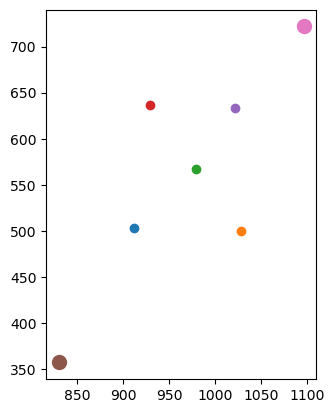

In [13]:
fig, ax  =plt.subplots()
for (x,y) in pts:
    ax.scatter(x,y)
    
ax.scatter(xmi,ymi, s=100)
ax.scatter(xma,yma, s=100)
ax.set_aspect("equal")
plt.show()

In [38]:
def train(train_loader, model, criterion, optimizer, epoch, args):
    losses = AverageMeter('Loss', ':.4f')
    top1 = AverageMeter('Accuracy', ':6.3f')
    progress = ProgressMeter(len(train_loader),
                             [losses, top1],
                             prefix="Epoch: [{}]".format(epoch))

    # switch to train mode
    model.train()

    for i, (images, target) in enumerate(train_loader):

        images = images.cuda()
        target = target.cuda()

        # compute output
        output = model(images)
        loss = criterion(output, target)

        # measure accuracy and record loss
        acc1, _ = accuracy(output, target, topk=(1, 5))
        losses.update(loss.item(), images.size(0))
        top1.update(acc1[0], images.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print loss and accuracy
        if i % args.print_freq == 0:
            progress.display(i, log_txt_path)

    return top1.avg, losses.avg


def validate(val_loader, model, criterion, args):
    losses = AverageMeter('Loss', ':.4f')
    top1 = AverageMeter('Accuracy', ':6.3f')
    progress = ProgressMeter(len(val_loader),
                             [losses, top1],
                             prefix='Test: ')

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        for i, (images, target) in enumerate(val_loader):
            images = images.cuda()
            target = target.cuda()

            # compute output
            output = model(images)
            loss = criterion(output, target)

            # measure accuracy and record loss
            acc1, _ = accuracy(output, target, topk=(1, 5))
            losses.update(loss.item(), images.size(0))
            top1.update(acc1[0], images.size(0))

            if i % args.print_freq == 0:
                progress.display(i, log_txt_path)

        # TODO: this should also be done with the ProgressMeter
        print('Current Accuracy: {top1.avg:.3f}'.format(top1=top1))
        with open(log_txt_path, 'a') as f:
            f.write('Current Accuracy: {top1.avg:.3f}'.format(top1=top1) + '\n')
    return top1.avg, losses.avg


def save_checkpoint(state, is_best):
    torch.save(state, checkpoint_path)
    if is_best:
        shutil.copyfile(checkpoint_path, best_checkpoint_path)